In [1]:
import numpy as np
import scipy
import random
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import FastICA
from sklearn.manifold import TSNE 
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
#from fcmeans import FCM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from sklearn.feature_selection import f_classif
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import sklearn

In [2]:
import pathlib

## Prepare data 

In [3]:
df = pd.read_csv(pathlib.Path('..', 'data','USCensus1990.data.csv'))

dAge = df['dAge']
dHispanic = df['dHispanic']
iYearwrk = df['iYearwrk']
iSex = df['iSex']

del(df['caseid'],df['dAge'],df['dHispanic'],df['iYearwrk'],df['iSex'])
df

,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,iEnglish,iFeb55,...,iSubfam2,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,dYrsserv
0,0,1,0,0,5,3,2,2,1,0,...,0,0,5,0,2,1,1,0,11,0
1,1,1,0,0,7,5,2,2,0,0,...,0,0,1,0,2,1,1,0,5,0
2,1,2,0,0,7,4,2,2,0,0,...,0,0,2,0,2,1,1,0,10,0
3,1,2,0,0,1,3,2,2,0,0,...,0,0,1,0,1,1,1,0,10,0
4,1,1,0,0,0,0,2,2,0,0,...,0,3,0,0,0,2,2,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458280,1,2,0,0,0,0,2,2,0,0,...,0,3,0,0,0,2,2,1,7,1
2458281,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
2458282,3,1,0,0,1,2,2,2,1,0,...,0,0,5,0,2,1,1,0,11,0
2458283,0,1,0,0,1,3,2,2,0,0,...,0,0,1,0,2,1,1,0,10,0


In [215]:
# df.info()
# df.dropna(inplace=True)
# df

## Feature Engineering 

In [330]:
!pip install git+https://github.com/MaxHalford/prince.git > /dev/null

  Running command git clone --filter=blob:none -q https://github.com/MaxHalford/prince.git /tmp/pip-req-build-sfc4mqb_
You should consider upgrading via the '/home/maayan/anaconda3/envs/data-science/bin/python -m pip install --upgrade pip' command.


In [5]:
import prince

In [6]:
def sample_reduce(df, frac=0.01, n_components=-1):
    mca = prince.MCA(n_components=-1)
    df_partial = df.sample(frac=frac)
    df_partial_encoded = pd.get_dummies(df_partial, columns=df_partial.columns)
    
    mca = mca.fit(df_partial_encoded)
    df_reduced_partial = mca.transform(df_partial_encoded)
    
    return df_reduced_partial, df_partial_encoded, mca

In [7]:
df_reduced_partial, df_partial, mca = sample_reduce(df)

In [8]:
df_reduced_partial.to_numpy()[:,:2].shape

(24583, 2)

## Clustering 

In [9]:
external_vars = [
    (dAge, 'age'),
    (dHispanic, 'hispanic'),
    (iYearwrk, 'Yearwrk'),
    (iSex, 'sex')
]

In [10]:
len(dAge.unique())

8

In [11]:
len(dHispanic.unique())

10

In [12]:
len(iYearwrk.unique())

8

In [13]:
len(iSex.unique())

2

In [14]:
dHispanic

0          0
1          0
2          0
3          0
4          0
          ..
2458280    0
2458281    0
2458282    0
2458283    7
2458284    3
Name: dHispanic, Length: 2458285, dtype: int64

### clustering 

In [15]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 15

In [16]:
from collections import defaultdict


#ac_silhoutte = []
models_list = [(KMeans, 'kmeans'), (AgglomerativeClustering, 'ac'), (GaussianMixture, 'gmm')]

silhoutte = {
    'mca': defaultdict(lambda: defaultdict(list)),
    'none': defaultdict(lambda: defaultdict(list))
}

mi_data = {
    'mca': defaultdict(lambda: defaultdict(lambda: defaultdict(list))),
    'none': defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
}


for i in range(MIN_CLUSTERS, MAX_CLUSTERS):
    print(f'Number of clusters {i}')
    n_samples = 30

    for sample_num in range(n_samples):
        df_reduced_partial, df_partial, mca = sample_reduce(df, frac=0.001)
        idx = df_partial.index
        for data, features in [(df_reduced_partial, 'mca'), (df_partial, 'none')]:
            print(f'with {features}')

            features_mat = data.to_numpy()

            for Clstr, name in models_list:
                print(f'{name}:')
                try:
                    ac = Clstr(n_clusters=i).fit(features_mat)
                    ac_labels = ac.labels_
                except:
                    ac = Clstr(n_components=i).fit(features_mat)
                    ac_labels = ac.predict(features_mat)
                
                silhouette_avg = silhouette_score(features_mat, ac_labels)
                silhoutte[features][name][i].append(silhouette_avg)
                print(
                            "For n_clusters =",
                            i,
                            "The average silhouette_score is :",
                            silhouette_avg,
                    )
                unique_counts = np.unique(ac_labels,return_counts=True)
                print(unique_counts)

                for var, var_text in external_vars:
                    subset_var = var[idx]
                    mi_score = normalized_mutual_info_score(subset_var, ac_labels)
                    print(f'{var_text}: {mi_score}')
                    mi_data[features][name][i][var_text].append(mi_score)
                print('-'*10)
        print('-'*20)

Number of clusters 2
with mca
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.39686474966456775
(array([0, 1], dtype=int32), array([1857,  601]))
age: 0.3914560163508024
hispanic: 0.008398670094308109
Yearwrk: 0.5066127391565547
sex: 0.0015414513080279889
----------
ac:
For n_clusters = 2 The average silhouette_score is : 0.3861262355105483
(array([0, 1]), array([1909,  549]))
age: 0.34637185294996
hispanic: 0.009641986860137968
Yearwrk: 0.4709613069132362
sex: 0.0020797994942990928
----------
gmm:
For n_clusters = 2 The average silhouette_score is : 0.39578059292976053
(array([0, 1]), array([1855,  603]))
age: 0.3898640105651292
hispanic: 0.008337934829727068
Yearwrk: 0.5044753546056578
sex: 0.0014135984813106216
----------
with none
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.21423484331605494
(array([0, 1], dtype=int32), array([1261, 1197]))
age: 0.23806139962888226
hispanic: 0.0033702554204119
Yearwrk: 0.5857351567696507
sex: 0.005263364702992594
-

For n_clusters = 2 The average silhouette_score is : 0.20329641471262705
(array([0, 1]), array([1310, 1148]))
age: 0.18836533277909934
hispanic: 0.004309140730364955
Yearwrk: 0.5200918725564062
sex: 0.011790248592357852
----------
gmm:
For n_clusters = 2 The average silhouette_score is : 0.2072806109309125
(array([0, 1]), array([1140, 1318]))
age: 0.22179976240006916
hispanic: 0.003988003041499439
Yearwrk: 0.5638376522508748
sex: 0.011408035851447283
----------
--------------------
with mca
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.4041951570028247
(array([0, 1], dtype=int32), array([1842,  616]))
age: 0.3936043337883488
hispanic: 0.004736151212327346
Yearwrk: 0.5194871779645555
sex: 0.003269550456968114
----------
ac:
For n_clusters = 2 The average silhouette_score is : 0.39762676395877716
(array([0, 1]), array([1836,  622]))
age: 0.35438156221455575
hispanic: 0.00486427395469581
Yearwrk: 0.47529696202126404
sex: 0.0015124951036110338
----------
gmm:
For n_cluster

For n_clusters = 2 The average silhouette_score is : 0.3371948909783787
(array([0, 1]), array([1007, 1451]))
age: 0.24298400575229095
hispanic: 0.004531417462199377
Yearwrk: 0.513262404231825
sex: 0.023029184505261327
----------
with none
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.22094804292746043
(array([0, 1], dtype=int32), array([ 615, 1843]))
age: 0.39085840831831464
hispanic: 0.005391408603876122
Yearwrk: 0.5144592640435305
sex: 0.0005332469565763322
----------
ac:
For n_clusters = 2 The average silhouette_score is : 0.22173958629935298
(array([0, 1]), array([1874,  584]))
age: 0.3827608373871336
hispanic: 0.005482706017563316
Yearwrk: 0.5273976671816584
sex: 0.0008120793574963706
----------
gmm:
For n_clusters = 2 The average silhouette_score is : 0.20739114832249608
(array([0, 1]), array([1286, 1172]))
age: 0.23675250605736936
hispanic: 0.0029695232359880823
Yearwrk: 0.5554345730107728
sex: 0.012873530667836986
----------
--------------------
with mca
kmeans

with mca
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.4048288948601762
(array([0, 1], dtype=int32), array([1794,  664]))
age: 0.40947590296383984
hispanic: 0.005695568763882906
Yearwrk: 0.5350408228636183
sex: 0.00390673617985278
----------
ac:
For n_clusters = 2 The average silhouette_score is : 0.39403906868397237
(array([0, 1]), array([1787,  671]))
age: 0.36885413252771715
hispanic: 0.007252789652671191
Yearwrk: 0.49149515165966945
sex: 0.0026806350806314046
----------
gmm:
For n_clusters = 2 The average silhouette_score is : 0.4045826631892745
(array([0, 1]), array([1794,  664]))
age: 0.407245234629996
hispanic: 0.00641781763925222
Yearwrk: 0.5350408228636183
sex: 0.0037062061198089597
----------
with none
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.23187860943761346
(array([0, 1], dtype=int32), array([1791,  667]))
age: 0.41040540255251634
hispanic: 0.005646571226239011
Yearwrk: 0.5345201910678007
sex: 0.00379456825191112
----------
ac:
For n_

For n_clusters = 2 The average silhouette_score is : 0.22176470866859982
(array([0, 1]), array([1877,  581]))
age: 0.37979242320086887
hispanic: 0.010773256192061128
Yearwrk: 0.5313430985239687
sex: 0.0032171721599450424
----------
gmm:
For n_clusters = 2 The average silhouette_score is : 0.20957442923817898
(array([0, 1]), array([1322, 1136]))
age: 0.2366908173106108
hispanic: 0.007363537278312417
Yearwrk: 0.5610909840774291
sex: 0.008042685881216982
----------
--------------------
with mca
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.4100672172777246
(array([0, 1], dtype=int32), array([1836,  622]))
age: 0.3959572990628603
hispanic: 0.0050057234372053
Yearwrk: 0.5273893844438513
sex: 0.00021977497672976947
----------
ac:
For n_clusters = 2 The average silhouette_score is : 0.3989180360672868
(array([0, 1]), array([1879,  579]))
age: 0.3520420298142033
hispanic: 0.0030105507775038303
Yearwrk: 0.48508277560133556
sex: 9.415736494635779e-05
----------
gmm:
For n_cluste

For n_clusters = 2 The average silhouette_score is : 0.17834265737885516
(array([0, 1]), array([1341, 1117]))
age: 0.17263386051956323
hispanic: 0.019895685877242643
Yearwrk: 0.3253813578898832
sex: 0.0009109676462024771
----------
with none
kmeans:
For n_clusters = 2 The average silhouette_score is : 0.20876657142686247
(array([0, 1], dtype=int32), array([1096, 1362]))
age: 0.2343938824807399
hispanic: 0.0025670527695122076
Yearwrk: 0.5988339484725679
sex: 0.009449887987741054
----------
ac:
For n_clusters = 2 The average silhouette_score is : 0.21657890373243252
(array([0, 1]), array([1913,  545]))
age: 0.3708688351748506
hispanic: 0.009395504971718004
Yearwrk: 0.5231243491670907
sex: 0.0010347976151680255
----------
gmm:
For n_clusters = 2 The average silhouette_score is : 0.2153109195834021
(array([0, 1]), array([1889,  569]))
age: 0.37524622600670915
hispanic: 0.009112393371864392
Yearwrk: 0.5063430027932759
sex: 0.0012829254912329951
----------
--------------------
with mca
kmean

For n_clusters = 3 The average silhouette_score is : 0.23040683088354683
(array([0, 1, 2]), array([1125,  548,  785]))
age: 0.3689872201039044
hispanic: 0.00441360145148962
Yearwrk: 0.7129065761785547
sex: 0.008482942431238337
----------
--------------------
with mca
kmeans:
For n_clusters = 3 The average silhouette_score is : 0.4509705517234182
(array([0, 1, 2], dtype=int32), array([ 722,  583, 1153]))
age: 0.39325329770650996
hispanic: 0.009128478827820209
Yearwrk: 0.7210434782779179
sex: 0.014666840274357924
----------
ac:
For n_clusters = 3 The average silhouette_score is : 0.41788127450676105
(array([0, 1, 2]), array([1307,  579,  572]))
age: 0.39617247965947955
hispanic: 0.011859144639877804
Yearwrk: 0.6350054641300649
sex: 0.006186620525281961
----------
gmm:
For n_clusters = 3 The average silhouette_score is : 0.40424983030626976
(array([0, 1, 2]), array([577, 998, 883]))
age: 0.39407576017747253
hispanic: 0.010100065911558839
Yearwrk: 0.6407999688801902
sex: 0.0102174912378860

For n_clusters = 3 The average silhouette_score is : 0.3923639573267595
(array([0, 1, 2]), array([ 832,  524, 1102]))
age: 0.30419923087960576
hispanic: 0.021978491529422585
Yearwrk: 0.5280023180148891
sex: 0.02571668444163612
----------
gmm:
For n_clusters = 3 The average silhouette_score is : 0.3550876843692468
(array([0, 1, 2]), array([1395, 1048,   15]))
age: 0.22210306758990095
hispanic: 0.006175784808206533
Yearwrk: 0.5491251269939234
sex: 0.012486426657518009
----------
with none
kmeans:
For n_clusters = 3 The average silhouette_score is : 0.23171270209893163
(array([0, 1, 2], dtype=int32), array([ 775,  546, 1137]))
age: 0.36395652132568046
hispanic: 0.010250456392955914
Yearwrk: 0.7160313154870229
sex: 0.016568322810767255
----------
ac:
For n_clusters = 3 The average silhouette_score is : 0.2313806617439465
(array([0, 1, 2]), array([ 779,  545, 1134]))
age: 0.3635776947203402
hispanic: 0.009816635887327948
Yearwrk: 0.7137372402676856
sex: 0.01615046253020547
----------
gmm:
F

For n_clusters = 3 The average silhouette_score is : 0.2335097179074003
(array([0, 1, 2]), array([ 774,  574, 1110]))
age: 0.3696466612592769
hispanic: 0.004088616243821988
Yearwrk: 0.7177687823333836
sex: 0.01766275025373295
----------
gmm:
For n_clusters = 3 The average silhouette_score is : 0.23365436128578948
(array([0, 1, 2]), array([1107,  574,  777]))
age: 0.36902124675922926
hispanic: 0.004128357822359296
Yearwrk: 0.7198404464425264
sex: 0.017783339208505448
----------
--------------------
with mca
kmeans:
For n_clusters = 3 The average silhouette_score is : 0.4543344326546713
(array([0, 1, 2], dtype=int32), array([ 602, 1091,  765]))
age: 0.3924212689676473
hispanic: 0.011330431508962777
Yearwrk: 0.7259167791293362
sex: 0.02100507816155254
----------
ac:
For n_clusters = 3 The average silhouette_score is : 0.3904545837641722
(array([0, 1, 2]), array([1356,  618,  484]))
age: 0.358129661671592
hispanic: 0.016194765550771883
Yearwrk: 0.6073133752514932
sex: 0.038507534552795306


For n_clusters = 3 The average silhouette_score is : 0.41440156846373793
(array([0, 1, 2]), array([883, 582, 993]))
age: 0.3669899644591563
hispanic: 0.020879301850853797
Yearwrk: 0.6478553426948881
sex: 0.014552505580085652
----------
gmm:
For n_clusters = 3 The average silhouette_score is : 0.3924012545152337
(array([0, 1, 2]), array([971, 571, 916]))
age: 0.40365790827840786
hispanic: 0.0028294480633882153
Yearwrk: 0.6302478761712652
sex: 0.011946168970617486
----------
with none
kmeans:
For n_clusters = 3 The average silhouette_score is : 0.23784818861940574
(array([0, 1, 2], dtype=int32), array([ 582,  760, 1116]))
age: 0.38383263009799234
hispanic: 0.003868896334766686
Yearwrk: 0.7190625171800091
sex: 0.017932743139062114
----------
ac:
For n_clusters = 3 The average silhouette_score is : 0.2373884195835715
(array([0, 1, 2]), array([ 766,  580, 1112]))
age: 0.38319524640255814
hispanic: 0.003894389820405096
Yearwrk: 0.7250342289694192
sex: 0.017095886087435282
----------
gmm:
For

For n_clusters = 3 The average silhouette_score is : 0.23894250638616643
(array([0, 1, 2]), array([ 746,  602, 1110]))
age: 0.3807784359093593
hispanic: 0.005750586585733708
Yearwrk: 0.7275164184401652
sex: 0.012564023908210648
----------
gmm:
For n_clusters = 3 The average silhouette_score is : 0.23927125285669468
(array([0, 1, 2]), array([ 756,  602, 1100]))
age: 0.38048302416406315
hispanic: 0.005444243429939597
Yearwrk: 0.7272364699540068
sex: 0.012468383875513807
----------
--------------------
with mca
kmeans:
For n_clusters = 3 The average silhouette_score is : 0.4466530285441005
(array([0, 1, 2], dtype=int32), array([1079,  761,  618]))
age: 0.3862384439181265
hispanic: 0.007083756678088055
Yearwrk: 0.7245918912585306
sex: 0.01201228643989692
----------
ac:
For n_clusters = 3 The average silhouette_score is : 0.38149821080645296
(array([0, 1, 2]), array([ 785,  621, 1052]))
age: 0.2928877967856909
hispanic: 0.01810650335245787
Yearwrk: 0.5101956831956012
sex: 0.0256055741992374

with mca
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.4623113621766754
(array([0, 1, 2, 3], dtype=int32), array([ 680,  192,  567, 1019]))
age: 0.3491811800328081
hispanic: 0.05348721157267732
Yearwrk: 0.6455534779366742
sex: 0.015768127617641705
----------
ac:
For n_clusters = 4 The average silhouette_score is : 0.45149315667557627
(array([0, 1, 2, 3]), array([1013,  565,  681,  199]))
age: 0.3443340140275651
hispanic: 0.05357194300695482
Yearwrk: 0.6189119724734424
sex: 0.01786389998306489
----------
gmm:
For n_clusters = 4 The average silhouette_score is : 0.3840822486857903
(array([0, 1, 2, 3]), array([348, 558, 763, 789]))
age: 0.33633253594666673
hispanic: 0.012257738857915923
Yearwrk: 0.5440909763283783
sex: 0.08983235623870894
----------
with none
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.21159028905185726
(array([0, 1, 2, 3], dtype=int32), array([ 220,  567, 1122,  549]))
age: 0.3658789968290836
hispanic: 0.011674168769828798
Yearwrk: 0.8

For n_clusters = 4 The average silhouette_score is : 0.3669126230645211
(array([0, 1, 2, 3]), array([814, 579, 403, 662]))
age: 0.3609923084891334
hispanic: 0.04172663536671097
Yearwrk: 0.5382861950981096
sex: 0.004513008463081614
----------
with none
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.21104988960633927
(array([0, 1, 2, 3], dtype=int32), array([1129,  577,  549,  203]))
age: 0.37226491471857764
hispanic: 0.004931692431002388
Yearwrk: 0.806670649979952
sex: 0.01025296698505384
----------
ac:
For n_clusters = 4 The average silhouette_score is : 0.20621379891731997
(array([0, 1, 2, 3]), array([1129,  608,  542,  179]))
age: 0.38536553928096007
hispanic: 0.004895686003386529
Yearwrk: 0.7606284942807163
sex: 0.007966829067676703
----------
gmm:
For n_clusters = 4 The average silhouette_score is : 0.1680841160931991
(array([0, 1, 2, 3]), array([737, 324, 812, 585]))
age: 0.3574318127350962
hispanic: 0.008578323180685491
Yearwrk: 0.6545188601906575
sex: 0.039521990

For n_clusters = 4 The average silhouette_score is : 0.20984341362969192
(array([0, 1, 2, 3]), array([1163,  585,  495,  215]))
age: 0.37857278732922867
hispanic: 0.006383673831057524
Yearwrk: 0.7918841168754068
sex: 0.015506414498892817
----------
gmm:
For n_clusters = 4 The average silhouette_score is : 0.17959267753075214
(array([0, 1, 2, 3]), array([728, 563, 449, 718]))
age: 0.36610352616780234
hispanic: 0.007087583550470561
Yearwrk: 0.6480891003580247
sex: 0.027377243407496848
----------
--------------------
with mca
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.4702760996073493
(array([0, 1, 2, 3], dtype=int32), array([ 681, 1007,  595,  175]))
age: 0.3641868534212698
hispanic: 0.05032298941189066
Yearwrk: 0.657835426239041
sex: 0.014926056302158392
----------
ac:
For n_clusters = 4 The average silhouette_score is : 0.4476596549459151
(array([0, 1, 2, 3]), array([1112,  169,  619,  558]))
age: 0.3305194002249802
hispanic: 0.05214347915075508
Yearwrk: 0.599590688

with mca
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.4704048528584881
(array([0, 1, 2, 3], dtype=int32), array([1052,  570,  656,  180]))
age: 0.35248243717321914
hispanic: 0.049617932146993976
Yearwrk: 0.674621966941341
sex: 0.01122568671568319
----------
ac:
For n_clusters = 4 The average silhouette_score is : 0.45438546811715286
(array([0, 1, 2, 3]), array([1129,  180,  604,  545]))
age: 0.32835523565657015
hispanic: 0.04153210025327242
Yearwrk: 0.6029943889172596
sex: 0.008249777943412934
----------
gmm:
For n_clusters = 4 The average silhouette_score is : 0.39354656066656835
(array([0, 1, 2, 3]), array([844, 569, 407, 638]))
age: 0.34748855487365726
hispanic: 0.04551204145550367
Yearwrk: 0.5677571598439706
sex: 0.009225939506367787
----------
with none
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.21376015876438553
(array([0, 1, 2, 3], dtype=int32), array([ 530,  191,  572, 1165]))
age: 0.371171136468914
hispanic: 0.010878445426895882
Yearwrk: 0

For n_clusters = 4 The average silhouette_score is : 0.3944997725081468
(array([0, 1, 2, 3]), array([827, 664, 390, 577]))
age: 0.3464017139191758
hispanic: 0.0339259698556218
Yearwrk: 0.556168377721448
sex: 0.008332713594503535
----------
with none
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.22032217307369154
(array([0, 1, 2, 3], dtype=int32), array([ 532, 1124,  583,  219]))
age: 0.3681613334887233
hispanic: 0.014153556348517133
Yearwrk: 0.8058139845499536
sex: 0.016113926883088384
----------
ac:
For n_clusters = 4 The average silhouette_score is : 0.21515091383727267
(array([0, 1, 2, 3]), array([1132,  582,  562,  182]))
age: 0.3765084218278212
hispanic: 0.014051053767874225
Yearwrk: 0.7761237560723325
sex: 0.010949284864892498
----------
gmm:
For n_clusters = 4 The average silhouette_score is : 0.22032217307369154
(array([0, 1, 2, 3]), array([ 583, 1124,  219,  532]))
age: 0.3681613334887233
hispanic: 0.014153556348517133
Yearwrk: 0.8058139845499535
sex: 0.016113

For n_clusters = 4 The average silhouette_score is : 0.21220503857955594
(array([0, 1, 2, 3]), array([1108,  593,  529,  228]))
age: 0.37202304369032174
hispanic: 0.012238916244691284
Yearwrk: 0.795868215833144
sex: 0.013066652801699935
----------
gmm:
For n_clusters = 4 The average silhouette_score is : 0.18211159209390734
(array([0, 1, 2, 3]), array([394, 594, 749, 721]))
age: 0.36750344176220573
hispanic: 0.010461660914230841
Yearwrk: 0.6423755643828861
sex: 0.03266577372597999
----------
--------------------
with mca
kmeans:
For n_clusters = 4 The average silhouette_score is : 0.45681846774322904
(array([0, 1, 2, 3], dtype=int32), array([ 721,  173, 1004,  560]))
age: 0.3515354109650694
hispanic: 0.04018978364697172
Yearwrk: 0.6478761089348432
sex: 0.013692593847807546
----------
ac:
For n_clusters = 4 The average silhouette_score is : 0.4473649274327294
(array([0, 1, 2, 3]), array([993, 534, 728, 203]))
age: 0.33164855981965474
hispanic: 0.04212812587827745
Yearwrk: 0.615760296710

For n_clusters = 5 The average silhouette_score is : 0.10173274837028738
(array([0, 1, 2, 3, 4]), array([172, 443, 743, 697, 403]))
age: 0.364789332853244
hispanic: 0.009612955624129848
Yearwrk: 0.6142753596347117
sex: 0.03892053821455883
----------
--------------------
with mca
kmeans:
For n_clusters = 5 The average silhouette_score is : 0.4724911250231337
(array([0, 1, 2, 3, 4], dtype=int32), array([219, 564, 824, 170, 681]))
age: 0.35370145353014554
hispanic: 0.03376858416585091
Yearwrk: 0.6037636533110177
sex: 0.05898666889303442
----------
ac:
For n_clusters = 5 The average silhouette_score is : 0.4668634763897242
(array([0, 1, 2, 3, 4]), array([593, 978, 712, 159,  16]))
age: 0.34041505499458524
hispanic: 0.036188363455282625
Yearwrk: 0.6109486004283429
sex: 0.015425071124195628
----------
gmm:
For n_clusters = 5 The average silhouette_score is : 0.3987193678403242
(array([0, 1, 2, 3, 4]), array([343, 800, 564, 578, 173]))
age: 0.36988436147298787
hispanic: 0.01234774203743918
Ye

with mca
kmeans:
For n_clusters = 5 The average silhouette_score is : 0.4619682506590812
(array([0, 1, 2, 3, 4], dtype=int32), array([694, 221, 566, 803, 174]))
age: 0.3442602343178655
hispanic: 0.056547514058966644
Yearwrk: 0.5908250067228964
sex: 0.0539101165605922
----------
ac:
For n_clusters = 5 The average silhouette_score is : 0.444053260721874
(array([0, 1, 2, 3, 4]), array([599, 193, 704, 179, 783]))
age: 0.32277142731059655
hispanic: 0.04874984106393119
Yearwrk: 0.5691622841669157
sex: 0.045408073052286106
----------
gmm:
For n_clusters = 5 The average silhouette_score is : 0.41077971165942356
(array([0, 1, 2, 3, 4]), array([569, 206, 794, 789, 100]))
age: 0.3688028843145024
hispanic: 0.013168697204906038
Yearwrk: 0.5951724092060837
sex: 0.08174894907516153
----------
with none
kmeans:
For n_clusters = 5 The average silhouette_score is : 0.1841682013620151
(array([0, 1, 2, 3, 4], dtype=int32), array([660, 570, 557, 434, 237]))
age: 0.36287548186756147
hispanic: 0.011784091952

For n_clusters = 5 The average silhouette_score is : 0.4666710226436436
(array([0, 1, 2, 3, 4]), array([613, 567, 278, 826, 174]))
age: 0.31909405334310903
hispanic: 0.03969352878672014
Yearwrk: 0.5281672716933142
sex: 0.07962397504262528
----------
gmm:
For n_clusters = 5 The average silhouette_score is : 0.4043964548838
(array([0, 1, 2, 3, 4]), array([572, 705, 176, 628, 377]))
age: 0.355951573973476
hispanic: 0.03738175283673013
Yearwrk: 0.5308476914982942
sex: 0.04092720246084519
----------
with none
kmeans:
For n_clusters = 5 The average silhouette_score is : 0.18279158886492988
(array([0, 1, 2, 3, 4], dtype=int32), array([655, 556, 577, 456, 214]))
age: 0.36300752317359986
hispanic: 0.00749009231610392
Yearwrk: 0.7286330721076396
sex: 0.03314441761849952
----------
ac:
For n_clusters = 5 The average silhouette_score is : 0.1707656949224536
(array([0, 1, 2, 3, 4]), array([580, 576, 739, 186, 377]))
age: 0.3643625610137945
hispanic: 0.010223057621750454
Yearwrk: 0.71270009528149
se

For n_clusters = 5 The average silhouette_score is : 0.3530502047561777
(array([0, 1, 2, 3, 4]), array([726, 604, 278, 647, 203]))
age: 0.3526919042141073
hispanic: 0.02535834588584063
Yearwrk: 0.6015838745004208
sex: 0.029339637339378773
----------
with none
kmeans:
For n_clusters = 5 The average silhouette_score is : 0.18375547661917369
(array([0, 1, 2, 3, 4], dtype=int32), array([607, 431, 514, 204, 702]))
age: 0.3603429475688342
hispanic: 0.009082799551748184
Yearwrk: 0.7285205967452625
sex: 0.03322783367484373
----------
ac:
For n_clusters = 5 The average silhouette_score is : 0.17724483499685376
(array([0, 1, 2, 3, 4]), array([630, 504, 517, 200, 607]))
age: 0.35281980923168316
hispanic: 0.014730004296485018
Yearwrk: 0.719958111007942
sex: 0.03153688517188272
----------
gmm:
For n_clusters = 5 The average silhouette_score is : 0.18340420917668096
(array([0, 1, 2, 3, 4]), array([514, 204, 704, 607, 429]))
age: 0.3603961208877826
hispanic: 0.009100591737739019
Yearwrk: 0.7286171262

For n_clusters = 5 The average silhouette_score is : 0.18896741351963806
(array([0, 1, 2, 3, 4], dtype=int32), array([210, 695, 519, 429, 605]))
age: 0.36539158251255227
hispanic: 0.008391535485173424
Yearwrk: 0.7323568120601474
sex: 0.03613111759894422
----------
ac:
For n_clusters = 5 The average silhouette_score is : 0.18246024151372264
(array([0, 1, 2, 3, 4]), array([711, 417, 521, 205, 604]))
age: 0.3607169153885022
hispanic: 0.015013625770311397
Yearwrk: 0.7290432740125283
sex: 0.025967565433660512
----------
gmm:
For n_clusters = 5 The average silhouette_score is : 0.14620587892563966
(array([0, 1, 2, 3, 4]), array([ 226, 1124,  519,  210,  379]))
age: 0.3843497942110082
hispanic: 0.007203177533513121
Yearwrk: 0.7682324003963937
sex: 0.01608456320440693
----------
--------------------
with mca
kmeans:
For n_clusters = 5 The average silhouette_score is : 0.4568245380652302
(array([0, 1, 2, 3, 4], dtype=int32), array([550, 835, 658, 231, 184]))
age: 0.34370790399667855
hispanic: 0

For n_clusters = 5 The average silhouette_score is : 0.17730721987439907
(array([0, 1, 2, 3, 4]), array([654, 615, 536, 198, 455]))
age: 0.36837847450563266
hispanic: 0.014385486396939099
Yearwrk: 0.6947066707164831
sex: 0.024248112402191376
----------
gmm:
For n_clusters = 5 The average silhouette_score is : 0.14361164891867734
(array([0, 1, 2, 3, 4]), array([ 414, 1103,  573,  197,  171]))
age: 0.3823654614964936
hispanic: 0.009828660441784659
Yearwrk: 0.7645518124024173
sex: 0.010714172018168983
----------
--------------------
with mca
kmeans:
For n_clusters = 5 The average silhouette_score is : 0.4812348037196547
(array([0, 1, 2, 3, 4], dtype=int32), array([932, 719, 597, 186,  24]))
age: 0.3707811670863679
hispanic: 0.0518871832055337
Yearwrk: 0.6306287609935962
sex: 0.010722678340359124
----------
ac:
For n_clusters = 5 The average silhouette_score is : 0.4544113898442405
(array([0, 1, 2, 3, 4]), array([651, 747, 306, 566, 188]))
age: 0.3206299717061057
hispanic: 0.03937777773861

For n_clusters = 6 The average silhouette_score is : 0.17142956235982648
(array([0, 1, 2, 3, 4, 5]), array([545, 585, 507, 228, 444, 149]))
age: 0.3561562699052841
hispanic: 0.01691273363682546
Yearwrk: 0.687396700990079
sex: 0.04907947775817533
----------
gmm:
For n_clusters = 6 The average silhouette_score is : 0.13465691964244317
(array([0, 1, 2, 3, 4, 5]), array([  84, 1132,  187,  213,  442,  400]))
age: 0.38365497826477807
hispanic: 0.009261198223987311
Yearwrk: 0.7373716082398364
sex: 0.0476075173868044
----------
--------------------
with mca
kmeans:
For n_clusters = 6 The average silhouette_score is : 0.4890486633873858
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([132, 836, 217, 552, 548, 173]))
age: 0.3435608924390181
hispanic: 0.03684419277393049
Yearwrk: 0.6006824814045438
sex: 0.056622134444834535
----------
ac:
For n_clusters = 6 The average silhouette_score is : 0.47037216251421865
(array([0, 1, 2, 3, 4, 5]), array([309, 580, 816, 524, 167,  62]))
age: 0.3148562914494

For n_clusters = 6 The average silhouette_score is : 0.17545884872684683
(array([0, 1, 2, 3, 4, 5]), array([573, 603, 342, 191, 255, 494]))
age: 0.3512984685646081
hispanic: 0.01655341947793614
Yearwrk: 0.6866871761840153
sex: 0.05125370750932118
----------
gmm:
For n_clusters = 6 The average silhouette_score is : 0.16314835925747523
(array([0, 1, 2, 3, 4, 5]), array([230, 604, 420, 532, 415, 257]))
age: 0.34015872200877795
hispanic: 0.010262364324751036
Yearwrk: 0.6838205155709741
sex: 0.0583277066400661
----------
--------------------
with mca
kmeans:
For n_clusters = 6 The average silhouette_score is : 0.4740850131323969
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([193, 839, 562, 495, 182, 187]))
age: 0.35143591871690266
hispanic: 0.034123719154472744
Yearwrk: 0.6174647590288695
sex: 0.04708460853510347
----------
ac:
For n_clusters = 6 The average silhouette_score is : 0.46021005588872144
(array([0, 1, 2, 3, 4, 5]), array([546, 179,  67, 184, 948, 534]))
age: 0.3295116011809722


For n_clusters = 6 The average silhouette_score is : 0.15988158795975824
(array([0, 1, 2, 3, 4, 5]), array([640, 520, 482, 194, 528,  94]))
age: 0.3436336422080971
hispanic: 0.016945770555175942
Yearwrk: 0.6599284741088494
sex: 0.05422214340037652
----------
gmm:
For n_clusters = 6 The average silhouette_score is : 0.11322601174007198
(array([0, 1, 2, 3, 4, 5]), array([223,  50, 485, 699, 521, 480]))
age: 0.3445921825079947
hispanic: 0.022529354699357348
Yearwrk: 0.6923270849868716
sex: 0.028804847505171146
----------
--------------------
with mca
kmeans:
For n_clusters = 6 The average silhouette_score is : 0.4855708646076874
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([577, 846, 224, 618, 182,  11]))
age: 0.3407872451758127
hispanic: 0.06017920914774506
Yearwrk: 0.5768175557875038
sex: 0.07605015125349539
----------
ac:
For n_clusters = 6 The average silhouette_score is : 0.4799491226123311
(array([0, 1, 2, 3, 4, 5]), array([571, 831, 261, 563, 158,  74]))
age: 0.31913382447824695


For n_clusters = 6 The average silhouette_score is : 0.16771519054061743
(array([0, 1, 2, 3, 4, 5]), array([580, 575, 548, 176, 388, 191]))
age: 0.3698671682882548
hispanic: 0.013160674793022839
Yearwrk: 0.643554875278989
sex: 0.05312028496144753
----------
gmm:
For n_clusters = 6 The average silhouette_score is : 0.1713440129011257
(array([0, 1, 2, 3, 4, 5]), array([220, 202, 503, 547, 565, 421]))
age: 0.34776800933423146
hispanic: 0.011330452465506955
Yearwrk: 0.6872232727679305
sex: 0.2665679981490876
----------
--------------------
with mca
kmeans:
For n_clusters = 6 The average silhouette_score is : 0.48589883080068297
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([645, 829,  17, 589, 200, 178]))
age: 0.35265665335347024
hispanic: 0.04369310827402912
Yearwrk: 0.5839484391243975
sex: 0.062399245922456326
----------
ac:
For n_clusters = 6 The average silhouette_score is : 0.4676805140881233
(array([0, 1, 2, 3, 4, 5]), array([511, 939, 255, 558, 180,  15]))
age: 0.3162507210363025
h

For n_clusters = 6 The average silhouette_score is : 0.16244012700383303
(array([0, 1, 2, 3, 4, 5]), array([551, 439, 494, 226, 555, 193]))
age: 0.33119725651228266
hispanic: 0.01042495316471859
Yearwrk: 0.6751594468265939
sex: 0.04972622039787577
----------
gmm:
For n_clusters = 6 The average silhouette_score is : 0.18353926896949035
(array([0, 1, 2, 3, 4, 5]), array([ 555, 1176,  109,  278,  134,  206]))
age: 0.3702647946036399
hispanic: 0.010042722919821173
Yearwrk: 0.747340825159302
sex: 0.05789688696457945
----------
--------------------
with mca
kmeans:
For n_clusters = 6 The average silhouette_score is : 0.4757791031249
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([195, 551, 639, 865,  18, 190]))
age: 0.33693077360890994
hispanic: 0.04569396308461663
Yearwrk: 0.5821236149594251
sex: 0.06463482923936038
----------
ac:
For n_clusters = 6 The average silhouette_score is : 0.4637549373511709
(array([0, 1, 2, 3, 4, 5]), array([181, 814, 675, 194,  76, 518]))
age: 0.3112903839594999

For n_clusters = 6 The average silhouette_score is : 0.17772474242802933
(array([0, 1, 2, 3, 4, 5]), array([511, 596, 542, 216, 415, 178]))
age: 0.34821718158811726
hispanic: 0.012122535328114107
Yearwrk: 0.6974119790521576
sex: 0.04928462540483762
----------
gmm:
For n_clusters = 6 The average silhouette_score is : 0.09097606603028273
(array([0, 1, 2, 3, 4, 5]), array([566, 540, 442, 533, 154, 223]))
age: 0.3297639914626889
hispanic: 0.007462141462158189
Yearwrk: 0.7026405473269173
sex: 0.17851192466896934
----------
--------------------
with mca
kmeans:
For n_clusters = 6 The average silhouette_score is : 0.4861069575597638
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([161, 481, 225, 585, 175, 831]))
age: 0.3489753851834166
hispanic: 0.04151644386301897
Yearwrk: 0.6247129345706622
sex: 0.05862776748689358
----------
ac:
For n_clusters = 6 The average silhouette_score is : 0.469301547102084
(array([0, 1, 2, 3, 4, 5]), array([300, 953, 437, 556, 154,  58]))
age: 0.31810427529287716
h

For n_clusters = 7 The average silhouette_score is : 0.16392566884775514
(array([0, 1, 2, 3, 4, 5, 6]), array([596, 580, 493, 210, 324, 174,  81]))
age: 0.3613155974165074
hispanic: 0.006547906940888131
Yearwrk: 0.688653450841844
sex: 0.08787918880488729
----------
gmm:
For n_clusters = 7 The average silhouette_score is : 0.12624353172456856
(array([0, 1, 2, 3, 4, 5, 6]), array([ 70, 433, 212, 199, 544, 659, 341]))
age: 0.4083111893268687
hispanic: 0.011968983456811355
Yearwrk: 0.6950438697080221
sex: 0.030720902193023647
----------
--------------------
with mca
kmeans:
For n_clusters = 7 The average silhouette_score is : 0.5061991098597625
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([171, 475, 847, 537, 193,  85, 150]))
age: 0.34884129783136614
hispanic: 0.040079868866960744
Yearwrk: 0.6061608080336405
sex: 0.09384875598305296
----------
ac:
For n_clusters = 7 The average silhouette_score is : 0.4890773901094162
(array([0, 1, 2, 3, 4, 5, 6]), array([496, 265, 929, 506, 178,  68,

For n_clusters = 7 The average silhouette_score is : 0.15598574046392405
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([193, 578, 284, 435, 358, 252, 358]))
age: 0.3694784683720182
hispanic: 0.015238096045890166
Yearwrk: 0.6577677066204332
sex: 0.04610364504828566
----------
ac:
For n_clusters = 7 The average silhouette_score is : 0.1744432901551963
(array([0, 1, 2, 3, 4, 5, 6]), array([547, 463, 388, 178, 577, 200, 105]))
age: 0.3442522094023649
hispanic: 0.021930435930324982
Yearwrk: 0.652849397993879
sex: 0.06031888956589687
----------
gmm:
For n_clusters = 7 The average silhouette_score is : 0.17005423873610068
(array([0, 1, 2, 3, 4, 5, 6]), array([179, 579, 403, 545,  84, 463, 205]))
age: 0.35421698549139036
hispanic: 0.01291771838894932
Yearwrk: 0.6601745482979742
sex: 0.08796286247042492
----------
--------------------
with mca
kmeans:
For n_clusters = 7 The average silhouette_score is : 0.4940639813500992
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([185, 600, 498, 825

For n_clusters = 7 The average silhouette_score is : 0.39355685827461523
(array([0, 1, 2, 3, 4, 5, 6]), array([ 80, 557, 455, 738, 147, 258, 223]))
age: 0.3075097586129345
hispanic: 0.03474925973952039
Yearwrk: 0.445248088290674
sex: 0.0733613740698135
----------
with none
kmeans:
For n_clusters = 7 The average silhouette_score is : 0.17190352323986158
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([560, 348, 102, 224, 416, 468, 340]))
age: 0.34344233447089906
hispanic: 0.008913977190825562
Yearwrk: 0.6506570147324989
sex: 0.07517007345747047
----------
ac:
For n_clusters = 7 The average silhouette_score is : 0.15636000802337288
(array([0, 1, 2, 3, 4, 5, 6]), array([334, 559, 422, 245, 355, 471,  72]))
age: 0.3370861765382682
hispanic: 0.009901586865118744
Yearwrk: 0.6715953026864638
sex: 0.06508308942055122
----------
gmm:
For n_clusters = 7 The average silhouette_score is : 0.17781470436395885
(array([0, 1, 2, 3, 4, 5, 6]), array([562, 237, 243, 158, 545, 311, 402]))
age: 0.339733

For n_clusters = 7 The average silhouette_score is : 0.47244981235767514
(array([0, 1, 2, 3, 4, 5, 6]), array([644, 858, 524, 171,  70, 174,  17]))
age: 0.3269653126551381
hispanic: 0.03885315461617447
Yearwrk: 0.5703492146629233
sex: 0.04694976466096587
----------
gmm:
For n_clusters = 7 The average silhouette_score is : 0.3590011427634784
(array([0, 1, 2, 3, 4, 5, 6]), array([325, 362, 313, 696,  61, 152, 549]))
age: 0.34345031412092525
hispanic: 0.044293254082007995
Yearwrk: 0.5410901563992787
sex: 0.05290884150051586
----------
with none
kmeans:
For n_clusters = 7 The average silhouette_score is : 0.17217970889386797
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([253, 561, 515, 333, 208, 187, 401]))
age: 0.3327401614220682
hispanic: 0.01233485329820534
Yearwrk: 0.6465797065084675
sex: 0.057516735867097345
----------
ac:
For n_clusters = 7 The average silhouette_score is : 0.1254144343317953
(array([0, 1, 2, 3, 4, 5, 6]), array([489, 501, 494, 189, 524, 184,  77]))
age: 0.368183

with mca
kmeans:
For n_clusters = 7 The average silhouette_score is : 0.4889768827727046
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([550, 178, 863, 188, 162,  13, 504]))
age: 0.35900466392634944
hispanic: 0.034896854265674175
Yearwrk: 0.6226433876889639
sex: 0.054981484194129925
----------
ac:
For n_clusters = 7 The average silhouette_score is : 0.4891928098197713
(array([0, 1, 2, 3, 4, 5, 6]), array([165, 504, 200, 157, 847, 516,  69]))
age: 0.33392610318041377
hispanic: 0.0362082348486905
Yearwrk: 0.6068475551421748
sex: 0.0368940600385656
----------
gmm:
For n_clusters = 7 The average silhouette_score is : 0.39968553013776026
(array([0, 1, 2, 3, 4, 5, 6]), array([137, 718, 460, 555, 149, 311, 128]))
age: 0.3161218613034841
hispanic: 0.04022428830947695
Yearwrk: 0.44653178331866955
sex: 0.07089247654348008
----------
with none
kmeans:
For n_clusters = 7 The average silhouette_score is : 0.1469384816811634
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([229, 329, 549, 455, 2

For n_clusters = 7 The average silhouette_score is : 0.1657954014890244
(array([0, 1, 2, 3, 4, 5, 6]), array([577, 167, 522, 247, 320, 441, 184]))
age: 0.35985751824122375
hispanic: 0.01650722445557317
Yearwrk: 0.6489822949718245
sex: 0.053677086642976546
----------
--------------------
with mca
kmeans:
For n_clusters = 7 The average silhouette_score is : 0.47353056869362903
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([862, 568, 174, 166, 502,  14, 172]))
age: 0.36503001984938305
hispanic: 0.033419735845982505
Yearwrk: 0.6240660023152353
sex: 0.046030537866226254
----------
ac:
For n_clusters = 7 The average silhouette_score is : 0.4841937811674891
(array([0, 1, 2, 3, 4, 5, 6]), array([557, 232,  63, 850, 186, 538,  32]))
age: 0.3287309080401266
hispanic: 0.03498331203927253
Yearwrk: 0.5338372505219736
sex: 0.06830626244246595
----------
gmm:
For n_clusters = 7 The average silhouette_score is : 0.36301437662277597
(array([0, 1, 2, 3, 4, 5, 6]), array([700, 520, 193, 430, 228, 188

For n_clusters = 8 The average silhouette_score is : 0.16891546556591433
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([567, 338, 522, 250, 258, 169, 258,  96]))
age: 0.3239147228662969
hispanic: 0.021807754271812033
Yearwrk: 0.6326643168906533
sex: 0.05656151001809074
----------
gmm:
For n_clusters = 8 The average silhouette_score is : 0.170245562103286
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([168, 567, 252, 236, 521, 240,  97, 377]))
age: 0.33749844768460996
hispanic: 0.011390421374057266
Yearwrk: 0.6418825086815171
sex: 0.06872071975676626
----------
--------------------
with mca
kmeans:
For n_clusters = 8 The average silhouette_score is : 0.48602427720881153
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([824, 575, 429, 144,  18, 178, 190, 100]))
age: 0.3533198334114817
hispanic: 0.04573561714832633
Yearwrk: 0.6149107378051192
sex: 0.06416939852398923
----------
ac:
For n_clusters = 8 The average silhouette_score is : 0.48563887766538416
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([253

For n_clusters = 8 The average silhouette_score is : 0.16961109779307665
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([215, 582, 292, 415, 427,  89, 335, 103]))
age: 0.34482507693763087
hispanic: 0.022758133031302728
Yearwrk: 0.6499481797109995
sex: 0.06477142765380803
----------
ac:
For n_clusters = 8 The average silhouette_score is : 0.16382736830609704
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([582, 573, 429, 226, 326, 154,  75,  93]))
age: 0.34071258712831914
hispanic: 0.02122244573354595
Yearwrk: 0.6642193073047177
sex: 0.0712331592752462
----------
gmm:
For n_clusters = 8 The average silhouette_score is : 0.07020823735318629
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([276, 574, 149, 217, 154,  86, 569, 433]))
age: 0.35330716714276056
hispanic: 0.012364556024710148
Yearwrk: 0.6694098401619398
sex: 0.20596344079116954
----------
--------------------
with mca
kmeans:
For n_clusters = 8 The average silhouette_score is : 0.4453741452157098
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int

For n_clusters = 8 The average silhouette_score is : 0.3917380005400114
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([675, 538, 354, 306,  23, 169, 288, 105]))
age: 0.33682065710746173
hispanic: 0.04368908812688724
Yearwrk: 0.5372213883618656
sex: 0.06679132512455822
----------
with none
kmeans:
For n_clusters = 8 The average silhouette_score is : 0.08873349731756369
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([359, 377, 228, 280, 250, 432, 196, 336]))
age: 0.36815278636981374
hispanic: 0.01584051833839185
Yearwrk: 0.6306113823080391
sex: 0.03774935771537935
----------
ac:
For n_clusters = 8 The average silhouette_score is : 0.0920975180564025
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([602, 457, 223, 226, 332, 200, 350,  68]))
age: 0.34493490448367947
hispanic: 0.013459665767529579
Yearwrk: 0.643374727211302
sex: 0.07156238254309656
----------
gmm:
For n_clusters = 8 The average silhouette_score is : 0.17420567792442293
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([283, 523,  92, 575, 213

For n_clusters = 8 The average silhouette_score is : 0.4774373461828663
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([472, 858, 193, 525, 166,  62, 166,  16]))
age: 0.33734157455808833
hispanic: 0.04039426488105861
Yearwrk: 0.5969738970738074
sex: 0.040604144934740474
----------
gmm:
For n_clusters = 8 The average silhouette_score is : 0.37011326069493894
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([362, 689, 479, 177, 252, 102,  98, 299]))
age: 0.3291048462811811
hispanic: 0.03306562973460543
Yearwrk: 0.51967731477209
sex: 0.07176102688860747
----------
with none
kmeans:
For n_clusters = 8 The average silhouette_score is : 0.15144531126777394
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([322, 548, 218, 251, 305, 106, 409, 299]))
age: 0.3390146133805657
hispanic: 0.03290717250363888
Yearwrk: 0.6304888917381682
sex: 0.054190165443689146
----------
ac:
For n_clusters = 8 The average silhouette_score is : 0.13336857848447645
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([488, 493, 423, 202, 520,

with mca
kmeans:
For n_clusters = 8 The average silhouette_score is : 0.5047000322382947
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([529, 185, 170, 494, 846, 159,  35,  40]))
age: 0.3605006157860242
hispanic: 0.043483030861313325
Yearwrk: 0.6099886418229729
sex: 0.05498305516193402
----------
ac:
For n_clusters = 8 The average silhouette_score is : 0.5103304984641795
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([237, 839, 524,  58, 175, 531,  34,  60]))
age: 0.3366459349293821
hispanic: 0.04241713621221567
Yearwrk: 0.5280257021916824
sex: 0.07185863064024141
----------
gmm:
For n_clusters = 8 The average silhouette_score is : 0.34678276093665383
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([180, 313, 359, 428, 713, 176,  45, 244]))
age: 0.34784762525330765
hispanic: 0.04113172929978848
Yearwrk: 0.5486998800116637
sex: 0.045582721355960046
----------
with none
kmeans:
For n_clusters = 8 The average silhouette_score is : 0.10467503588086315
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), 

For n_clusters = 8 The average silhouette_score is : 0.1333103484886108
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 98, 544, 197, 361, 397, 295, 188, 378]))
age: 0.35563991012259466
hispanic: 0.037312573094918915
Yearwrk: 0.6524445090853279
sex: 0.05424907102532224
----------
--------------------
with mca
kmeans:
For n_clusters = 8 The average silhouette_score is : 0.48983928381526615
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([862, 551, 446, 175, 155,  17, 149, 103]))
age: 0.35591359420455604
hispanic: 0.038497403684791945
Yearwrk: 0.6197789462295873
sex: 0.09133974940103234
----------
ac:
For n_clusters = 8 The average silhouette_score is : 0.4821374333520185
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([962, 501,  59, 154, 175, 524,  67,  16]))
age: 0.3494400990225847
hispanic: 0.04261466537584245
Yearwrk: 0.5869042897572165
sex: 0.05329618185449817
----------
gmm:
For n_clusters = 8 The average silhouette_score is : 0.35216214598774825
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([22

For n_clusters = 9 The average silhouette_score is : 0.08269908833153337
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([398, 243, 181, 392, 218, 263, 193, 302, 268]))
age: 0.34490036944847335
hispanic: 0.010794764618947836
Yearwrk: 0.6182426185031
sex: 0.05484434366655894
----------
ac:
For n_clusters = 9 The average silhouette_score is : 0.09439214837931716
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([505, 380, 268, 273, 412, 174,  96, 173, 177]))
age: 0.32220891755134035
hispanic: 0.030179183510929058
Yearwrk: 0.6177843538783852
sex: 0.05023710105222786
----------
gmm:
For n_clusters = 9 The average silhouette_score is : 0.1410990824734122
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([585, 399,  90, 104, 345, 176, 353, 135, 271]))
age: 0.33911251922057845
hispanic: 0.0134381787496689
Yearwrk: 0.6542761851697585
sex: 0.13850777857494412
----------
--------------------
with mca
kmeans:
For n_clusters = 9 The average silhouette_score is : 0.45223520414448287
(array([0, 1, 2, 3, 4

For n_clusters = 9 The average silhouette_score is : 0.48304903239001207
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([163, 774, 212, 419, 160,  73,  16, 542,  99]))
age: 0.3319255528324629
hispanic: 0.03176696177509374
Yearwrk: 0.5843365857966532
sex: 0.06657680312851995
----------
gmm:
For n_clusters = 9 The average silhouette_score is : 0.3916273324421121
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([146, 302, 565, 177, 710,  94, 208,  16, 240]))
age: 0.3435023730632579
hispanic: 0.033375443928070285
Yearwrk: 0.5566936730472092
sex: 0.06334417613305095
----------
with none
kmeans:
For n_clusters = 9 The average silhouette_score is : 0.0867118583745994
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([225, 185, 268, 281, 424, 219, 173, 386, 297]))
age: 0.35476899370176174
hispanic: 0.015031220906612762
Yearwrk: 0.6072861000058598
sex: 0.0632597655833497
----------
ac:
For n_clusters = 9 The average silhouette_score is : 0.10221115801112396
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), arra

For n_clusters = 9 The average silhouette_score is : 0.07764929654500909
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 76, 417, 169, 313, 342, 388, 151, 234, 368]))
age: 0.36433694081286616
hispanic: 0.01543531865539839
Yearwrk: 0.6431899351695423
sex: 0.03385241809282362
----------
--------------------
with mca
kmeans:
For n_clusters = 9 The average silhouette_score is : 0.4588439085301573
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([445, 501, 515,  52, 197,  23, 488, 147,  90]))
age: 0.3378683335792291
hispanic: 0.03371903560116677
Yearwrk: 0.5219372613785572
sex: 0.05850239427595476
----------
ac:
For n_clusters = 9 The average silhouette_score is : 0.5050834478172561
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([862, 511,  68, 180, 154, 504,  16,  73,  90]))
age: 0.3178934640002956
hispanic: 0.029780477834066323
Yearwrk: 0.5422258010589481
sex: 0.07522025503996978
----------
gmm:
For n_clusters = 9 The average silhouette_score is : 0.3177552069404796
(array([0, 1, 2, 3, 4,

For n_clusters = 9 The average silhouette_score is : 0.14947099478508014
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([177, 225, 548, 291, 302, 238, 240, 245, 192]))
age: 0.37612467090704893
hispanic: 0.01479886092516051
Yearwrk: 0.6065780718196941
sex: 0.061205873575704624
----------
ac:
For n_clusters = 9 The average silhouette_score is : 0.14088654898951727
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([291, 320, 334, 245, 549, 258,  93, 225, 143]))
age: 0.3640414435416926
hispanic: 0.026432494370216993
Yearwrk: 0.6112077231759443
sex: 0.03518533537802101
----------
gmm:
For n_clusters = 9 The average silhouette_score is : 0.16008974338430065
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([283, 548,  97, 206, 319, 166, 285,  93, 461]))
age: 0.35183014300020116
hispanic: 0.02129513636341973
Yearwrk: 0.6004881734573979
sex: 0.10021582238733132
----------
--------------------
with mca
kmeans:
For n_clusters = 9 The average silhouette_score is : 0.5077004565079544
(array([0, 1, 2, 3

For n_clusters = 9 The average silhouette_score is : 0.4931484756042723
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([816, 170,  61, 556, 396, 187,  16, 178,  78]))
age: 0.3417593305682725
hispanic: 0.03419525347439319
Yearwrk: 0.6007353762592278
sex: 0.0735194507627295
----------
gmm:
For n_clusters = 9 The average silhouette_score is : 0.32993076693092394
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([142, 346, 645, 443, 168,  85, 198,  87, 344]))
age: 0.33629656027083116
hispanic: 0.03954897220785855
Yearwrk: 0.5466351619544343
sex: 0.069054099258014
----------
with none
kmeans:
For n_clusters = 9 The average silhouette_score is : 0.09033012895644396
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([199, 180,  98, 278, 341, 501, 263, 194, 404]))
age: 0.3643048943814656
hispanic: 0.030145265507226834
Yearwrk: 0.6132397634126816
sex: 0.057218125559988744
----------
ac:
For n_clusters = 9 The average silhouette_score is : 0.09516251392958189
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array

For n_clusters = 9 The average silhouette_score is : 0.14683974916297032
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([213, 595, 106, 307, 296, 207, 233, 211, 290]))
age: 0.3773169171677394
hispanic: 0.015523570258929467
Yearwrk: 0.6326740372713525
sex: 0.08381573385950891
----------
--------------------
with mca
kmeans:
For n_clusters = 9 The average silhouette_score is : 0.5044424507049167
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([174, 527,  87, 174, 180,  20, 828, 428,  40]))
age: 0.35663286924240156
hispanic: 0.0358378599781494
Yearwrk: 0.6055971712600643
sex: 0.07767490471948683
----------
ac:
For n_clusters = 9 The average silhouette_score is : 0.4942504133539484
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([185, 819, 221, 176, 385, 530,  19,  40,  83]))
age: 0.34456826513435623
hispanic: 0.03510353911161281
Yearwrk: 0.6136296977786229
sex: 0.07575474237803724
----------
gmm:
For n_clusters = 9 The average silhouette_score is : 0.4093937695102718
(array([0, 1, 2, 3, 4,

For n_clusters = 9 The average silhouette_score is : 0.14489600844177242
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32), array([158, 272, 528, 215,  96, 245, 357, 286, 301]))
age: 0.33038616787082614
hispanic: 0.02610377994530824
Yearwrk: 0.6133807675549844
sex: 0.05071988587407016
----------
ac:
For n_clusters = 9 The average silhouette_score is : 0.07902689137317481
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([308, 483, 387, 251, 393, 306,  81, 114, 135]))
age: 0.3124884031361342
hispanic: 0.024084700582051168
Yearwrk: 0.6160305237471756
sex: 0.0641653788323086
----------
gmm:
For n_clusters = 9 The average silhouette_score is : 0.12273966016123374
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([106, 528, 181, 133, 169, 194, 250, 219, 678]))
age: 0.3306545020833768
hispanic: 0.01766127524415137
Yearwrk: 0.6311718503541741
sex: 0.0525060275880239
----------
--------------------
Number of clusters 10
with mca
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.4663983734266185

with mca
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.4689160824542423
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([466, 507, 444, 393,  14,  45, 102, 161, 159, 167]))
age: 0.334448712770701
hispanic: 0.035941820721016426
Yearwrk: 0.5627170705787801
sex: 0.0856991311221672
----------
ac:
For n_clusters = 10 The average silhouette_score is : 0.45678171902232473
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([174, 507, 163, 105, 162,  45,  14, 424, 460, 404]))
age: 0.3267603494910076
hispanic: 0.03518071702344963
Yearwrk: 0.5685927470018649
sex: 0.0877145349523332
----------
gmm:
For n_clusters = 10 The average silhouette_score is : 0.30149419853555637
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([337, 167,  64, 281, 615, 160, 255, 130,  14, 435]))
age: 0.3310115741704813
hispanic: 0.03604050654869577
Yearwrk: 0.49858336688006794
sex: 0.07774355436153975
----------
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.1467787363621403

For n_clusters = 10 The average silhouette_score is : 0.09056190689651925
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([125, 369, 191, 258, 307, 192, 110, 395, 309, 202]))
age: 0.3606152989527978
hispanic: 0.015188155990049261
Yearwrk: 0.5873402947986918
sex: 0.0835502617519842
----------
ac:
For n_clusters = 10 The average silhouette_score is : 0.08127850922503398
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([311, 431, 363, 220, 213, 120, 298, 101,  66, 335]))
age: 0.35520231736942043
hispanic: 0.029124887976098576
Yearwrk: 0.5973514234467766
sex: 0.0656795718370608
----------
gmm:
For n_clusters = 10 The average silhouette_score is : 0.10453942347854184
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 98, 191, 160, 218, 297, 194, 398, 181, 510, 211]))
age: 0.3496949595414831
hispanic: 0.029568790959989686
Yearwrk: 0.5954791933695979
sex: 0.06241420612791672
----------
--------------------
with mca
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.480193468

with mca
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.4852470619181816
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([543, 555, 332, 463, 154, 184,  14,  83,  37,  93]))
age: 0.35870049590375164
hispanic: 0.031671303499363396
Yearwrk: 0.5366487703406694
sex: 0.08110801264531228
----------
ac:
For n_clusters = 10 The average silhouette_score is : 0.4511696683282122
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([170, 555, 195, 184, 398,  56,  11, 408,  84, 397]))
age: 0.33500219700892936
hispanic: 0.03229705004035609
Yearwrk: 0.5656407560238798
sex: 0.08206316498217384
----------
gmm:
For n_clusters = 10 The average silhouette_score is : 0.2934395711430867
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([157, 160, 255, 451, 310, 185, 148,  36, 626, 130]))
age: 0.33008665319088665
hispanic: 0.036372097543861386
Yearwrk: 0.5012885034763788
sex: 0.051019044535013665
----------
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.08545111880

For n_clusters = 10 The average silhouette_score is : 0.08695263245758615
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([298, 194,  99, 385, 257, 196, 323, 224, 103, 379]))
age: 0.3656797883727286
hispanic: 0.024593426685706733
Yearwrk: 0.6099236239142104
sex: 0.07552073917125635
----------
ac:
For n_clusters = 10 The average silhouette_score is : 0.08183218678031945
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([503, 310, 393, 138, 215, 146,  69, 202, 180, 302]))
age: 0.33901601222000005
hispanic: 0.016380090128183138
Yearwrk: 0.6025734577808731
sex: 0.06317410959378181
----------
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08032150030130462
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([242, 194, 262, 182, 120, 204, 391, 183, 379, 301]))
age: 0.36678634827823586
hispanic: 0.015004880588995876
Yearwrk: 0.6126227061784727
sex: 0.0860873666944435
----------
--------------------
with mca
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.4656853

with mca
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.46988774627386765
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 53, 374, 541,  84,  77, 436, 179,  21, 142, 551]))
age: 0.3490727029121624
hispanic: 0.02489304592396482
Yearwrk: 0.5329642592274482
sex: 0.08366008565366036
----------
ac:
For n_clusters = 10 The average silhouette_score is : 0.4311753900358944
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([526, 543,  75, 160, 366,  20, 183, 466,  39,  80]))
age: 0.33990011242410195
hispanic: 0.024421155870187602
Yearwrk: 0.5530161846025252
sex: 0.07621155318608513
----------
gmm:
For n_clusters = 10 The average silhouette_score is : 0.3701344240911978
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([101, 632, 453, 314, 175, 129, 205, 343,  85,  21]))
age: 0.3246145752133614
hispanic: 0.023351110723427795
Yearwrk: 0.523186163126049
sex: 0.07748495948002264
----------
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.08322796981757

For n_clusters = 10 The average silhouette_score is : 0.0924333248953971
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([389, 438, 197,  98, 167, 129, 230, 165, 341, 304]))
age: 0.36003383453145865
hispanic: 0.015043654140142287
Yearwrk: 0.6063092347719465
sex: 0.08363544873866464
----------
ac:
For n_clusters = 10 The average silhouette_score is : 0.08984046331118456
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([471, 234, 346, 202, 189, 165,  98,  77, 311, 365]))
age: 0.32481181442593166
hispanic: 0.019689554700323
Yearwrk: 0.6036730894708255
sex: 0.06918064120855799
----------
gmm:
For n_clusters = 10 The average silhouette_score is : 0.14401376400165858
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 87, 554, 211, 165, 212, 292, 382, 152, 208, 195]))
age: 0.34998479904520785
hispanic: 0.02349541576772019
Yearwrk: 0.6122580974342392
sex: 0.11102346011937635
----------
--------------------
with mca
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.4511291352

with mca
kmeans:
For n_clusters = 11 The average silhouette_score is : 0.5026344254920357
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([576, 157, 404,  67, 491,  41,  87,  10,  91, 110, 424]))
age: 0.35250282071700717
hispanic: 0.0325282728186022
Yearwrk: 0.5571343783631312
sex: 0.06774549246541851
----------
ac:
For n_clusters = 11 The average silhouette_score is : 0.48478408288028163
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([482, 162, 575, 388,  99,  87,   9, 455,  43,  85,  73]))
age: 0.34651271390278854
hispanic: 0.03209045352682657
Yearwrk: 0.5631326240152095
sex: 0.06621818908601584
----------
gmm:
For n_clusters = 11 The average silhouette_score is : 0.41708702783493223
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([400, 578,  68,  97, 304,   9, 150,  89, 238, 158, 367]))
age: 0.3274472788807907
hispanic: 0.03732895764660764
Yearwrk: 0.5438581960052781
sex: 0.0630218406626769
----------
with none
kmeans:
For n_clusters

For n_clusters = 11 The average silhouette_score is : 0.32379823042910405
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([111, 381, 464, 377,  22, 168, 163, 165, 344,  97, 166]))
age: 0.3104071640506406
hispanic: 0.030086211810256214
Yearwrk: 0.4895180312275429
sex: 0.08873989900749532
----------
with none
kmeans:
For n_clusters = 11 The average silhouette_score is : 0.09482404376310152
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([ 92, 174,  82, 303, 389, 216, 105, 379, 203, 313, 202]))
age: 0.3530667571557526
hispanic: 0.02738910903378366
Yearwrk: 0.5974640763703543
sex: 0.07250445402159943
----------
ac:
For n_clusters = 11 The average silhouette_score is : 0.08375819954630227
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([288, 317, 280, 206, 158, 239, 255, 174,  82,  80, 379]))
age: 0.3386009976434271
hispanic: 0.023894205983813744
Yearwrk: 0.5903270902220084
sex: 0.06538414096020446
----------
gmm:
For n_clusters = 11 The aver

For n_clusters = 11 The average silhouette_score is : 0.07795756492607187
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([288, 284, 330, 263, 345, 286, 170, 148, 210,  69,  65]))
age: 0.3291694655112551
hispanic: 0.021185717729995016
Yearwrk: 0.5804176841982787
sex: 0.07139134818332721
----------
gmm:
For n_clusters = 11 The average silhouette_score is : 0.08092934515775113
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([300, 192, 130, 180, 219, 262, 199, 229, 363, 257, 127]))
age: 0.3628438823956697
hispanic: 0.017661051501349515
Yearwrk: 0.5854207701108063
sex: 0.05140406751617212
----------
--------------------
with mca
kmeans:
For n_clusters = 11 The average silhouette_score is : 0.4964292100061752
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([ 56, 583, 564,  87, 405,  75, 119,  16,  69, 318, 166]))
age: 0.3506945198769369
hispanic: 0.037016681430891256
Yearwrk: 0.5586420431929723
sex: 0.07692914026500737
----------
ac:
For n_cl

with mca
kmeans:
For n_clusters = 11 The average silhouette_score is : 0.5127090735591902
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([582, 518, 430, 103, 140,  73, 394,  34,  90,  75,  19]))
age: 0.35714117538602447
hispanic: 0.041958718354661875
Yearwrk: 0.5634186274089473
sex: 0.07393514346022516
----------
ac:
For n_clusters = 11 The average silhouette_score is : 0.48334155992278793
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([502, 127,  82, 605,  65,  14, 357, 466, 110,  31,  99]))
age: 0.3655855901537709
hispanic: 0.040803685665602066
Yearwrk: 0.5559796103512584
sex: 0.07517038257458447
----------
gmm:
For n_clusters = 11 The average silhouette_score is : 0.393223023849461
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 99, 601, 369, 234, 256,  58, 171,  81,  86, 411,  92]))
age: 0.3437812941477075
hispanic: 0.03736985340909317
Yearwrk: 0.5499336768408283
sex: 0.0597834595008384
----------
with none
kmeans:
For n_clusters

For n_clusters = 11 The average silhouette_score is : 0.3494927721644813
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([496, 363, 381,  83, 297, 367,  53, 179, 104,   7, 128]))
age: 0.32563216071441486
hispanic: 0.04228351641074322
Yearwrk: 0.48910615954790654
sex: 0.04681210858621301
----------
with none
kmeans:
For n_clusters = 11 The average silhouette_score is : 0.08281642995921028
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([274, 365,  82, 217, 367, 325, 207, 173, 184, 125, 139]))
age: 0.3681746051477805
hispanic: 0.016537346243292356
Yearwrk: 0.5857110547480893
sex: 0.05521598140810452
----------
ac:
For n_clusters = 11 The average silhouette_score is : 0.08202623321642603
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([331, 270, 191, 201, 208, 286, 104,  75, 358, 150, 284]))
age: 0.33528972881991315
hispanic: 0.027009184848008277
Yearwrk: 0.5780944346995117
sex: 0.06481660125690052
----------
gmm:
For n_clusters = 11 The av

For n_clusters = 11 The average silhouette_score is : 0.07753761576320925
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([256, 326, 199, 242, 244, 178,  68,  81, 271, 359, 234]))
age: 0.3371999545144098
hispanic: 0.025341590292309684
Yearwrk: 0.5933315877036275
sex: 0.07113385569091342
----------
gmm:
For n_clusters = 11 The average silhouette_score is : 0.08064048740272957
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([380, 163, 229, 377, 175, 238, 213, 178, 186, 184, 135]))
age: 0.359157637681374
hispanic: 0.015889145422457316
Yearwrk: 0.596236342871012
sex: 0.12011074100986154
----------
--------------------
with mca
kmeans:
For n_clusters = 11 The average silhouette_score is : 0.4497444180613994
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([570, 164, 334, 391, 128, 153,  16,  64,  50, 103, 485]))
age: 0.3369983884174309
hispanic: 0.030043884141732834
Yearwrk: 0.562467578787795
sex: 0.0680822818720085
----------
ac:
For n_cluste

with mca
kmeans:
For n_clusters = 11 The average silhouette_score is : 0.4876188818582063
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32), array([418,  53, 172, 521, 422, 117,  49,  13,  69, 100, 524]))
age: 0.34383577433217416
hispanic: 0.03594406134795184
Yearwrk: 0.5505808669551824
sex: 0.07688281379423037
----------
ac:
For n_clusters = 11 The average silhouette_score is : 0.47237387896361244
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([498, 171,  56, 396, 126, 524,  51,  13, 465,  98,  60]))
age: 0.3374229163178542
hispanic: 0.03495033708036117
Yearwrk: 0.5632612741920306
sex: 0.07841449492032447
----------
gmm:
For n_clusters = 11 The average silhouette_score is : 0.3933807069121032
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([367, 669, 455, 135,  67, 259, 158,  55, 106,  96,  91]))
age: 0.340872354227673
hispanic: 0.038069456626425184
Yearwrk: 0.5397094419159139
sex: 0.06918667647916878
----------
with none
kmeans:
For n_clusters

For n_clusters = 12 The average silhouette_score is : 0.39154719939215354
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 85,  61, 180, 401, 298, 387,  11,  89,  94,  90, 233, 529]))
age: 0.3262329399088585
hispanic: 0.03393331668800116
Yearwrk: 0.5199928604962104
sex: 0.07457524233195352
----------
gmm:
For n_clusters = 12 The average silhouette_score is : 0.34289047655391613
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 65,  78, 154, 293, 443, 162, 312, 627, 151,   7,  77,  89]))
age: 0.3367273854911763
hispanic: 0.038015087766828666
Yearwrk: 0.5406965064948646
sex: 0.071941766984849
----------
with none
kmeans:
For n_clusters = 12 The average silhouette_score is : 0.08934349479081659
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([272, 223, 412, 102, 215, 247, 204,  76, 175, 174, 209, 149]))
age: 0.36266947003706257
hispanic: 0.025898992652699113
Yearwrk: 0.5743271594331034
sex: 0.08886066111506466
----------
ac:
Fo

For n_clusters = 12 The average silhouette_score is : 0.3919430617002574
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([164, 609, 557, 324,  32, 134, 264,  18, 105, 178,  25,  48]))
age: 0.34568542131793184
hispanic: 0.034901728517496344
Yearwrk: 0.5478215545612745
sex: 0.05833384128041958
----------
with none
kmeans:
For n_clusters = 12 The average silhouette_score is : 0.08582267502942496
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([170, 277, 259, 160, 190, 215, 105, 172, 213,  93, 402, 202]))
age: 0.3612863648188607
hispanic: 0.02678714282929281
Yearwrk: 0.5736410636710036
sex: 0.08985305895025247
----------
ac:
For n_clusters = 12 The average silhouette_score is : 0.07173631890155062
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([282, 220, 189, 251, 192, 432,  78, 275, 255,  71, 158,  55]))
age: 0.3584915509054114
hispanic: 0.02822675219652169
Yearwrk: 0.591176131136927
sex: 0.07187003007531378
----------
gmm:
For

For n_clusters = 12 The average silhouette_score is : 0.09466880674399597
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([238, 379,  98,  61, 213, 295, 215, 185,  99, 326, 169, 180]))
age: 0.3581024518872711
hispanic: 0.020608081702658192
Yearwrk: 0.5764894978955809
sex: 0.08428999229303882
----------
ac:
For n_clusters = 12 The average silhouette_score is : 0.08168807990959326
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([359, 262, 199, 210, 379, 102, 267, 185,  72, 200, 129,  94]))
age: 0.3377998366409995
hispanic: 0.022364184730392346
Yearwrk: 0.5763769649039546
sex: 0.07228396036424066
----------
gmm:
For n_clusters = 12 The average silhouette_score is : 0.08377401254376976
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([279, 185, 105, 102, 161, 379, 129, 266, 117, 216, 258, 261]))
age: 0.36524447472756344
hispanic: 0.016627626409803205
Yearwrk: 0.5820049708744989
sex: 0.13447963167933785
----------
-----------------

For n_clusters = 12 The average silhouette_score is : 0.08833136920558096
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([479, 329, 365,  66, 149, 171,  90, 187, 252,  90, 148, 132]))
age: 0.34363231964970836
hispanic: 0.01899958035195729
Yearwrk: 0.575526375353137
sex: 0.06949094839968359
----------
gmm:
For n_clusters = 12 The average silhouette_score is : 0.1358272315180565
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 89, 550, 309, 145, 263, 126,  97, 147, 150, 219, 250, 113]))
age: 0.3136216523889728
hispanic: 0.02591935674780671
Yearwrk: 0.5963069533494499
sex: 0.1974561116388196
----------
--------------------
with mca
kmeans:
For n_clusters = 12 The average silhouette_score is : 0.467761377189551
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([526, 133, 516,  92, 104,  20, 340, 383, 166,  67,  65,  46]))
age: 0.33391368078653483
hispanic: 0.02593804695105589
Yearwrk: 0.5749684855858659
sex: 0.06785825544231715
-

For n_clusters = 12 The average silhouette_score is : 0.06932667228410894
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([175, 345,  95, 221, 212, 205, 149, 212, 319, 197, 166, 162]))
age: 0.3373560521788769
hispanic: 0.028284932314825446
Yearwrk: 0.5709222929969264
sex: 0.0741036739281486
----------
--------------------
with mca
kmeans:
For n_clusters = 12 The average silhouette_score is : 0.4778363628607673
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([ 88, 451, 541,  82, 187, 389,  69,  17, 372,  92,  39, 131]))
age: 0.3394810639541832
hispanic: 0.03158237843943243
Yearwrk: 0.5755628422084805
sex: 0.08597079101406645
----------
ac:
For n_clusters = 12 The average silhouette_score is : 0.4610465908382441
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 66, 186, 539, 404,  95, 416,  73,  16, 402,  92,  71,  98]))
age: 0.32936396741932145
hispanic: 0.03093299552741266
Yearwrk: 0.5591007586783537
sex: 0.08929736428939694


with mca
kmeans:
For n_clusters = 12 The average silhouette_score is : 0.4705662589662468
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([ 90, 476, 530, 385, 365,  17,  88,  72, 185, 149,  50,  51]))
age: 0.33158883310549414
hispanic: 0.037324581458217584
Yearwrk: 0.5752306702758602
sex: 0.07324622490755214
----------
ac:
For n_clusters = 12 The average silhouette_score is : 0.45439152143187966
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 79,  76, 191, 497, 432, 331,  17, 520,  49,  86,  91,  89]))
age: 0.32419108879839326
hispanic: 0.03649552966485505
Yearwrk: 0.5385466128236991
sex: 0.07310586934384289
----------
gmm:
For n_clusters = 12 The average silhouette_score is : 0.349111092930708
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([379, 493, 348, 139, 166,  74,  86, 110, 499,  63,  32,  69]))
age: 0.3137215041297773
hispanic: 0.037286974014704724
Yearwrk: 0.5296283680664663
sex: 0.061879223952490854
----------
wi

For n_clusters = 12 The average silhouette_score is : 0.4587484729319058
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([ 63,  98,  50, 176, 439, 538,  21,  87, 422, 354,  79, 131]))
age: 0.31743887775493945
hispanic: 0.03152204164171841
Yearwrk: 0.5623122082865122
sex: 0.07604556043490217
----------
gmm:
For n_clusters = 12 The average silhouette_score is : 0.3931681964926771
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([156, 500, 344,  21, 362,  92, 194, 116, 463,  37,  37, 136]))
age: 0.3156517459572536
hispanic: 0.033429449526647094
Yearwrk: 0.48679501859505675
sex: 0.07283522802385695
----------
with none
kmeans:
For n_clusters = 12 The average silhouette_score is : 0.08378862255340011
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32), array([174, 209, 199, 206, 213, 258, 254, 387,  74, 154, 227, 103]))
age: 0.36453741873603435
hispanic: 0.02264289596757239
Yearwrk: 0.5810840315957442
sex: 0.07916135437125044
----------
ac:
F

For n_clusters = 13 The average silhouette_score is : 0.33061559067807006
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([373, 448, 271, 348,  63,  75, 134, 215,  88,  86,  91, 170,  96]))
age: 0.3112562928411329
hispanic: 0.029834651371905177
Yearwrk: 0.5058269062295284
sex: 0.0756624880469466
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.08367381389811102
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([106, 170, 185, 231, 167,  87, 386, 187, 116, 192,  97, 302, 232]))
age: 0.36231337970708305
hispanic: 0.0169111236312883
Yearwrk: 0.5960332892639516
sex: 0.08891961241487424
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.05874728585733937
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([177, 233, 415, 167, 251, 264,  90, 214, 143, 126,  58, 210, 110]))
age: 0.3410329756819303
hispanic: 0.028152070640497354
Yearwrk: 0.5776928285299574
sex: 0.087924577

For n_clusters = 13 The average silhouette_score is : 0.3758923359648477
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([158, 486, 218, 124,  13, 340, 327, 361,  96,  27,  65, 170,  73]))
age: 0.3152900898921766
hispanic: 0.03707562398395634
Yearwrk: 0.5204963618092794
sex: 0.07195603275172674
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.08507429625148771
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([163, 221,  90,  93, 204, 225, 162, 414, 162, 173, 173, 209, 169]))
age: 0.3548760090062904
hispanic: 0.016261396090725383
Yearwrk: 0.5981215728529379
sex: 0.13727590835013395
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.07964116428001318
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([258, 310, 181, 221, 369, 141,  76, 263,  56,  95, 175, 179, 134]))
age: 0.35004581222420184
hispanic: 0.026099783370103036
Yearwrk: 0.5749660687719919
sex: 0.07849662

For n_clusters = 13 The average silhouette_score is : 0.26632983293154067
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([465, 396, 311, 109,  23,  69,  18, 220,  52, 141, 346, 164, 144]))
age: 0.3296579631070501
hispanic: 0.04069413870370465
Yearwrk: 0.49722398556063685
sex: 0.07815477933626439
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.08513715722256163
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([119, 202, 208, 306, 349, 105, 173, 355, 197, 110,  57, 198,  79]))
age: 0.33972015558183233
hispanic: 0.04017928783661756
Yearwrk: 0.5675537072564929
sex: 0.07602560517465166
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.07329571940978895
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([224, 219, 100, 244, 285, 344, 118, 190, 213, 173,  63, 159, 126]))
age: 0.3361797601696827
hispanic: 0.029766606533195693
Yearwrk: 0.5614748490258301
sex: 0.0757284

For n_clusters = 13 The average silhouette_score is : 0.34144000913324163
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([118, 385, 524, 318, 110,  20,  29, 201, 344, 130, 128,  76,  75]))
age: 0.31342273909457496
hispanic: 0.042173410599528116
Yearwrk: 0.5293608932342644
sex: 0.06274259364443972
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.0824406103267236
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([370, 278, 143, 202, 147, 223, 189, 205, 176,  99,  75, 120, 231]))
age: 0.3481912451752649
hispanic: 0.027850953754166963
Yearwrk: 0.5540505982742573
sex: 0.10021309086597566
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.07674866421001925
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([314, 219, 182, 158, 340, 119, 283,  91, 213, 238,  64,  73, 164]))
age: 0.32399337385083515
hispanic: 0.031835474729207974
Yearwrk: 0.5620487383696341
sex: 0.060513

For n_clusters = 13 The average silhouette_score is : 0.3557439914466681
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([330, 464, 320,  56,  92, 177,  15, 104, 386, 133, 126, 188,  67]))
age: 0.32962022819850245
hispanic: 0.03935830345754355
Yearwrk: 0.5109747606086034
sex: 0.07846553922137703
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.08371234658280029
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([182, 202, 177, 138, 207, 271,  80, 165, 384, 185,  94, 161, 212]))
age: 0.35569072754742026
hispanic: 0.030440973005008108
Yearwrk: 0.5589593532114703
sex: 0.08781415747250368
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.07422047909154446
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([350, 204, 243, 213, 198,  89,  72,  83, 151, 332, 193, 190, 140]))
age: 0.3606355586918423
hispanic: 0.023657521302210813
Yearwrk: 0.5636345378763065
sex: 0.0898810

For n_clusters = 13 The average silhouette_score is : 0.39233359763055603
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([190, 474, 368, 112, 125, 166, 159,  16,  83,  72, 294, 359,  40]))
age: 0.3180009705924956
hispanic: 0.03373791296132716
Yearwrk: 0.49539772127278836
sex: 0.06110370611294445
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.08570331349266974
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([ 50, 274, 183, 212, 154, 193, 185, 387, 199, 245,  81,  95, 200]))
age: 0.37180729185383377
hispanic: 0.029121239977621158
Yearwrk: 0.5734301965446369
sex: 0.07902472182824789
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.06709160077054098
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([302, 136, 380, 224, 201, 319,  72, 141,  53, 163, 151, 147, 169]))
age: 0.35474874808104123
hispanic: 0.026297687250312507
Yearwrk: 0.5724734912349486
sex: 0.07518

For n_clusters = 13 The average silhouette_score is : 0.34133187447530466
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([246, 467, 309,  68, 144, 263,  40,  72, 420,  89,  86, 125, 129]))
age: 0.3077618068532702
hispanic: 0.03213355601943113
Yearwrk: 0.5073382572983732
sex: 0.06844926451331004
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.07806715989237613
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([208, 235, 165, 152, 166,  94, 196, 222, 357, 124, 176, 195, 168]))
age: 0.3480234136346689
hispanic: 0.02682885191287955
Yearwrk: 0.5506560524449773
sex: 0.06108773961486977
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.06981083721602119
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([173, 230, 383, 187, 302, 172, 104, 210, 211, 140,  83,  60, 203]))
age: 0.32490069013867756
hispanic: 0.022561417466811486
Yearwrk: 0.559432734332502
sex: 0.078666709

For n_clusters = 13 The average silhouette_score is : 0.32266894227170434
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([469, 607, 328, 191, 123,  99,  64, 103,  87, 131, 120, 126,  10]))
age: 0.32412155807711324
hispanic: 0.03857171512303714
Yearwrk: 0.5467202866516971
sex: 0.07180366409860937
----------
with none
kmeans:
For n_clusters = 13 The average silhouette_score is : 0.08316087974609866
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32), array([394, 392, 282,  67, 154,  94, 180, 110, 167, 174, 158, 178, 108]))
age: 0.35914647071264383
hispanic: 0.031218263432042547
Yearwrk: 0.5803835616376567
sex: 0.18976299793344686
----------
ac:
For n_clusters = 13 The average silhouette_score is : 0.06699532546990919
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([245, 230, 196, 243, 130, 224,  86, 376,  53, 197, 219, 140, 119]))
age: 0.32670798245697413
hispanic: 0.02561862085434545
Yearwrk: 0.5675582767726417
sex: 0.096480

For n_clusters = 14 The average silhouette_score is : 0.47065758389110324
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([525, 603, 391,  25,  78, 166,  70,  10,  92, 210, 107, 120,  31,
        30]))
age: 0.3538227396885752
hispanic: 0.03236057822078743
Yearwrk: 0.5699425830495486
sex: 0.08022064501077791
----------
gmm:
For n_clusters = 14 The average silhouette_score is : 0.3686541940213153
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 83,  28, 462, 314, 633, 105, 129,  10,  48,  39, 171,  89, 221,
       126]))
age: 0.31983670099225425
hispanic: 0.03275136070622359
Yearwrk: 0.5210848632593426
sex: 0.08392907941108918
----------
with none
kmeans:
For n_clusters = 14 The average silhouette_score is : 0.08243026181810718
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([251, 185, 215, 140,  72, 142, 187, 113, 369, 112, 210,  56, 193,
       213]))
age: 0.3679515108664926
hispanic: 0.01625155

with mca
kmeans:
For n_clusters = 14 The average silhouette_score is : 0.44829357077792814
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([381,  39, 360,  54, 116, 462,  77, 176,  70,  10,  62,  26, 137,
       488]))
age: 0.3391495002010265
hispanic: 0.03550465088677744
Yearwrk: 0.5885080481121218
sex: 0.06848747250667729
----------
ac:
For n_clusters = 14 The average silhouette_score is : 0.45586233706844115
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([172, 418, 422,  91, 123, 490,  59, 437,  33,   9,  39, 106,  33,
        26]))
age: 0.3157641650951966
hispanic: 0.037755653076466014
Yearwrk: 0.5711764831948943
sex: 0.06939147522760479
----------
gmm:
For n_clusters = 14 The average silhouette_score is : 0.38341885292985967
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([372, 353, 452, 107, 354, 171,  28,  26, 144,  81,  71,  62, 228,
         9]))
age: 0.31241144114821606
hispanic: 0.035

For n_clusters = 14 The average silhouette_score is : 0.09210790098678329
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([276, 192,  60,  88, 338, 199,  99, 166, 214, 207, 193, 183,  92,
       151]))
age: 0.36059710884191876
hispanic: 0.034477762504739
Yearwrk: 0.561902609313912
sex: 0.08035340430028819
----------
--------------------
with mca
kmeans:
For n_clusters = 14 The average silhouette_score is : 0.465122314223877
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([ 61, 467, 494, 154, 121, 358, 175,  20,  56,  33, 104, 360,  23,
        32]))
age: 0.3282655691576498
hispanic: 0.0362988522334465
Yearwrk: 0.562622975321443
sex: 0.07104354384917551
----------
ac:
For n_clusters = 14 The average silhouette_score is : 0.44730230045193936
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 55, 364, 181, 393, 143,  64, 109, 494, 101,  20, 423,  56,  33,
        22]))
age: 0.319935981668474
hispanic

For n_clusters = 14 The average silhouette_score is : 0.07442969520253856
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([294, 122, 108, 182, 161, 184, 354, 118, 190, 267,  49, 100, 160,
       169]))
age: 0.3494268359059425
hispanic: 0.028317863870024673
Yearwrk: 0.5474126677571953
sex: 0.07442987253006973
----------
gmm:
For n_clusters = 14 The average silhouette_score is : 0.08203442904546972
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([131, 189, 219, 335, 174, 287, 194,  91, 143,  95,  67,  83, 349,
       101]))
age: 0.36639613268604726
hispanic: 0.030142039108121393
Yearwrk: 0.5497817095261548
sex: 0.06851798666271833
----------
--------------------
with mca
kmeans:
For n_clusters = 14 The average silhouette_score is : 0.41901641415608176
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([ 44, 180, 562, 169, 131, 117,  18, 304,  83,  64, 352, 131,  83,
       220]))
age: 0.33374856067666

For n_clusters = 14 The average silhouette_score is : 0.08951736798121639
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([100, 235, 361, 307, 178, 203, 185, 192, 217,  72, 137,  38,  61,
       172]))
age: 0.36664643687431947
hispanic: 0.016404282381473047
Yearwrk: 0.5568065690107618
sex: 0.07644288345346387
----------
ac:
For n_clusters = 14 The average silhouette_score is : 0.06975932083086199
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([422, 196, 115, 176, 312, 109, 133, 100, 169, 225, 149, 156,  55,
       141]))
age: 0.3495189962800148
hispanic: 0.0257712538078028
Yearwrk: 0.5543059200292539
sex: 0.07900438314807544
----------
gmm:
For n_clusters = 14 The average silhouette_score is : 0.07629972907177857
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([234,  97, 185, 230, 305, 154, 278,  85, 131,  96, 208, 191,  99,
       165]))
age: 0.34617123725769494
hispanic: 0.03216874839633365
Ye

For n_clusters = 14 The average silhouette_score is : 0.2662320817291046
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([440,  39, 117, 129, 174,  98, 188, 131, 467,  10, 296, 174, 173,
        22]))
age: 0.3285845010401732
hispanic: 0.037492279857678536
Yearwrk: 0.45899279354809724
sex: 0.06500009060117186
----------
with none
kmeans:
For n_clusters = 14 The average silhouette_score is : 0.08893392170941962
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([102, 402, 173, 276, 183,  94, 106, 187, 125, 136, 161, 167, 155,
       191]))
age: 0.36226511750637536
hispanic: 0.02895621333883393
Yearwrk: 0.5542159900341066
sex: 0.10495556550651464
----------
ac:
For n_clusters = 14 The average silhouette_score is : 0.06724072361137517
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([139,  98, 183, 188, 213, 121, 125, 254, 388, 173, 125, 155, 183,
       113]))
age: 0.33860605702902935
hispanic: 0.031795

For n_clusters = 14 The average silhouette_score is : 0.46907785645988265
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([167,  73, 371, 335, 472, 153, 110,  57,  86, 533,  32,  18,  29,
        22]))
age: 0.3390155166805563
hispanic: 0.038656190568432
Yearwrk: 0.5595761673462181
sex: 0.07141985980486185
----------
gmm:
For n_clusters = 14 The average silhouette_score is : 0.31836724041627223
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([169, 489, 112, 341, 139,  98,   4,  18, 101, 183, 163, 119,  81,
       441]))
age: 0.3067723711230379
hispanic: 0.03642651691909636
Yearwrk: 0.5163434445015479
sex: 0.10758546890462162
----------
with none
kmeans:
For n_clusters = 14 The average silhouette_score is : 0.0869102818488944
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([ 71, 185, 197, 172,  69, 313, 398, 207, 127, 161, 101, 174,  60,
       223]))
age: 0.37167213415337397
hispanic: 0.0193337138

with mca
kmeans:
For n_clusters = 14 The average silhouette_score is : 0.4365041962652675
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32), array([199, 510, 532, 138,  21,  84,  84, 318, 152,  30,  82,  25,  74,
       209]))
age: 0.3392884682583637
hispanic: 0.027978287514213454
Yearwrk: 0.5574299367266492
sex: 0.07088896256262824
----------
ac:
For n_clusters = 14 The average silhouette_score is : 0.41162142079754493
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([118, 127,  91,  39, 390, 246,  59,  75, 597, 476,  82, 111,  26,
        21]))
age: 0.32279342690992685
hispanic: 0.031039252751723874
Yearwrk: 0.5431532740559564
sex: 0.06683158302584807
----------
gmm:
For n_clusters = 14 The average silhouette_score is : 0.302777786520449
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([153, 313, 483, 422,  86,  77, 173,  82, 144,  21,  79, 295,  73,
        57]))
age: 0.3201177440859617
hispanic: 0.02590

In [17]:
silhoutte

{'mca': defaultdict(<function __main__.<lambda>()>,
             {'kmeans': defaultdict(list,
                          {2: [0.39686474966456775,
                            0.4037483280537746,
                            0.39850397715176683,
                            0.39431467932422615,
                            0.4042813016010011,
                            0.3904905282647345,
                            0.4041951570028247,
                            0.3939014810917259,
                            0.4028860872167189,
                            0.39316158053534983,
                            0.3995643017649678,
                            0.40370733905855455,
                            0.40291813409011334,
                            0.40080521812011005,
                            0.40280934614428465,
                            0.40951101984627664,
                            0.4013137575526213,
                            0.4048288948601762,
                            0.

In [18]:
mi_data['mca']['kmeans'][10]

defaultdict(list,
            {'age': [0.34607238126992057,
              0.3386592319658277,
              0.34158453223146484,
              0.35276180027673065,
              0.334448712770701,
              0.3482785239716712,
              0.34294278735535894,
              0.3419437943737737,
              0.33941294823330764,
              0.35807343007161735,
              0.35907937769491616,
              0.35289456633626737,
              0.3518190456792606,
              0.35870049590375164,
              0.3496232939434474,
              0.3399252458101511,
              0.3421383748957238,
              0.357793774198833,
              0.32963415642290445,
              0.35603194319000353,
              0.3318441170389238,
              0.34322329883684927,
              0.3490727029121624,
              0.35653772720062765,
              0.3482198929962651,
              0.3280767769116853,
              0.34507339793801917,
              0.34475200997556366,
          

In [19]:
import statistics


def mean_silhouette(features_type, algorithm, num_of_clusters, data=silhoutte):
    return statistics.mean(data[features_type][algorithm][num_of_clusters])

In [20]:
def mean_silhouette_by_num_clusters(features_type, algorithm, data=silhoutte):
    return [
                mean_silhouette(features_type, algorithm, num_of_clusters, data=data)
                for num_of_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS)
           ]

In [21]:
def mean_MI_by_num_clusters(features_type, algorithm, y_name, data=mi_data):
    return [
                statistics.mean(data[features_type][algorithm][num_of_clusters][y_name])
                for num_of_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS)
           ]

In [22]:
mi_data['none']['kmeans'][2]['age']

[0.23806139962888226,
 0.2382168240211233,
 0.23658163079923175,
 0.22769896612237833,
 0.2370115268779453,
 0.22339183208365976,
 0.24455267548061782,
 0.2373677050280588,
 0.24595610970726342,
 0.22490497999791595,
 0.38526349990268416,
 0.39085840831831464,
 0.2409825057619497,
 0.23830146523008924,
 0.2266144310599819,
 0.24438365980934174,
 0.2367844139350217,
 0.41040540255251634,
 0.39008994366327704,
 0.3880249986669551,
 0.23709902610644074,
 0.39351120831869024,
 0.2421396618520634,
 0.39720298259291353,
 0.2553688898184566,
 0.215773365517509,
 0.23737520080651112,
 0.224680508326917,
 0.2343938824807399,
 0.38989892369159623]

In [23]:
mean_MI_by_num_clusters('none', 'kmeans', 'age')

[0.2777632009386349,
 0.38014591586350255,
 0.3743130835451256,
 0.3607789736663495,
 0.34514273109760524,
 0.3544917634476471,
 0.3581730008351523,
 0.3557376077570933,
 0.3592086694640802,
 0.36452413390312316,
 0.3632677847129538,
 0.3608070398455163,
 0.359004673513847]

In [24]:
mean_silhouette('none', 'kmeans', 7)

0.15311955509457043

In [25]:
mean_silhouette_by_num_clusters('none', 'gmm')

[0.21127902772679427,
 0.22863135823108047,
 0.1900294728202458,
 0.17029966313408745,
 0.15200624135819368,
 0.13502173874789594,
 0.12876182820152082,
 0.11440274502426506,
 0.10602554576096156,
 0.1022004410570482,
 0.09596863055566571,
 0.09576727436628378,
 0.08483563405183199]

## Plots 

In [26]:
def plot_silhoutte(silhoutte):
    """
    Input: list of n silhoutte scores (where n is num of clusters compared)
    """
    num_of_clusters = [i for i in range(MIN_CLUSTERS, MAX_CLUSTERS)]#[2,3,4,5,6,7,8,9,10,11,12,13,14]
    assert len(num_of_clusters) == len(silhoutte), 'invalid configuration for MIN_CLUSTERS, MAX_CLUSTERS'
    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(num_of_clusters, silhoutte, 'bo-', color='black')
    plt.xlabel('i')
    plt.ylabel('Silhouette Score')
    plt.title('Identify the number of clusters using Silhouette Score')
    plt.show()

In [27]:
def plot(values, title):
    """
    Input: list of n scores (where n is num of clusters compared)
    """
    num_of_clusters = [i for i in range(MIN_CLUSTERS, MAX_CLUSTERS)]
    assert len(num_of_clusters) == len(values), 'invalid configuration for MIN_CLUSTERS, MAX_CLUSTERS'
    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(num_of_clusters, values, 'bo-', color='black')
    plt.xlabel('i')
    plt.ylabel(title)
    plt.title(f'Identify the number of clusters using {title}')
    plt.show()

In [251]:
def plot_silhouttes(silhouttes, titles):
    """
    Input: list of n silhoutte scores (where n is num of clusters compared)
    """
    num_of_clusters = [i for i in range(MIN_CLUSTERS, MAX_CLUSTERS)]
    fig, axs = plt.subplots(len(silhouttes), figsize=(8,8))
    fig.suptitle('Mean silhouette by number of clusters')
    # Set common labels
    #axs.set_xlabel('common xlabel')
    #axs.set_ylabel('common ylabel')
    for i, (silhoutte, title) in enumerate(zip(silhouttes, titles)):
        assert len(num_of_clusters) == len(silhoutte), 'invalid configuration for MIN_CLUSTERS, MAX_CLUSTERS'
        axs[i].set_title(title)
        #fig.figure()
        axs[i].plot(num_of_clusters, silhoutte, 'bo-', color='black')
    plt.xlabel('number of clusters')
    #plt.ylabel('Silhouette Score')
    fig.tight_layout()
    plt.savefig('mean_sil.svg', format='svg', dpi=1200)
    plt.show()

In [252]:
mean_sil_models = [mean_silhouette_by_num_clusters('none', model[1]) for model in models_list]
models_titles = [model[1] for model in models_list]

<ipython-input-251-8065b4464fac>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  axs[i].plot(num_of_clusters, silhoutte, 'bo-', color='black')


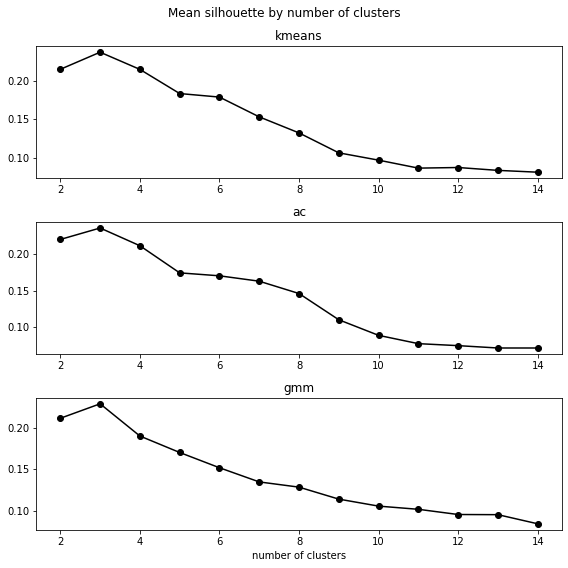

In [253]:
plot_silhouttes(mean_sil_models, models_titles)

In [199]:
silhoutte['mca']['dbscan'][NUMBER_OF_CLUSTERS] = []
for var, var_text in external_vars:
    mi_data[features]['dbscan'][NUMBER_OF_CLUSTERS][var_text] = []

In [200]:
i = NUMBER_OF_CLUSTERS
print(f'Number of clusters {i}')
n_samples = 30

for sample_num in range(n_samples):
    name = 'dbscan'
    df_reduced_partial, df_partial, mca = sample_reduce(df, frac=0.01)
    idx = df_partial.index
    for data, features in [(df_reduced_partial, 'mca')]:
        eps = 0.12
        min_s = 70
        ac = DBSCAN(eps=eps, min_samples=min_s)
        clustering = ac.fit(data)
        ac_labels = clustering.labels_
        
        labels = [y for y in ac_labels if y != -1]
        idx_without_outliers = [True if y != -1 else False for y in ac_labels]
        
        silhouette_avg = silhouette_score(data[idx_without_outliers], labels)
        silhoutte[features][name][i].append(silhouette_avg)
        print(
                    "For n_clusters =",
                    i,
                    "The average silhouette_score is :",
                    silhouette_avg,
            )
        unique_counts = np.unique(ac_labels,return_counts=True)
        print(unique_counts)

        for var, var_text in external_vars:

            
            subset_var = var[idx]
            
            subset_var = [y for i, y in enumerate(subset_var) if ac_labels[i] != -1]
            labels = [y for y in ac_labels if y != -1]
            mi_score = normalized_mutual_info_score(subset_var, labels)
            
            print(f'{var_text}: {mi_score}')
            
            mi_data[features][name][i][var_text].append(mi_score)
            
        print('-'*10)
    print('-'*20)

Number of clusters 10
For n_clusters = 10 The average silhouette_score is : 0.5726722700857112
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([3264, 5086, 4819, 8095,  753, 1208,  563,  262,  158,  189,  186]))
age: 0.3802301846638218
hispanic: 0.030079397992157385
Yearwrk: 0.6525529767617811
sex: 0.07272918424920241
----------
--------------------
For n_clusters = 10 The average silhouette_score is : 0.5706806149714395
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([3684, 7911, 5243, 4527,  709,  279,  554, 1164,  199,  130,  183]))
age: 0.3884461565078101
hispanic: 0.03499546574404126
Yearwrk: 0.6636473916431845
sex: 0.07996146039261819
----------
--------------------
For n_clusters = 10 The average silhouette_score is : 0.3630257454058007
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), array([3145, 9959, 7976,  216,  296,  578,  743,  214, 1240,  216]))
age: 0.25123706790484834
hispanic: 0.03589801743242078
Yearwrk: 0.5005234321519484
sex: 0.0638738796918

For n_clusters = 10 The average silhouette_score is : 0.5739995826708455
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([3267, 4755, 5129, 8089, 1176,  138,  265,  734,  206,  256,  568]))
age: 0.38232273475276457
hispanic: 0.029434431133459112
Yearwrk: 0.6555587856453124
sex: 0.07838786447504249
----------
--------------------
For n_clusters = 10 The average silhouette_score is : 0.5720939929845932
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([3293, 4836, 7970, 5145, 1150,  650,  244,  556,  293,  206,  240]))
age: 0.38356317563550213
hispanic: 0.033288026993122444
Yearwrk: 0.654909350563709
sex: 0.07464287310871488
----------
--------------------
For n_clusters = 10 The average silhouette_score is : 0.11010092006138374
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]), array([ 3310, 17958,  1120,   577,   123,   265,   244,   723,   263]))
age: 0.10389061172907188
hispanic: 0.05718152266528222
Yearwrk: 0.1576307390412543
sex: 0.08416891907462475
----------
----

In [202]:
silhoutte['mca']['dbscan'][NUMBER_OF_CLUSTERS]

[0.5726722700857112,
 0.5706806149714395,
 0.3630257454058007,
 0.5692974022343344,
 0.5684855967490529,
 0.090015007245469,
 0.5715907032670646,
 0.4092283174530889,
 0.5620355467464064,
 0.4016085482609371,
 0.5695446367214864,
 0.5693029177839113,
 0.41094003439443105,
 0.5768474241838671,
 0.4070100520756311,
 0.569607219494215,
 0.3540846316237529,
 0.36545915782357097,
 0.5713005006635334,
 0.547921275941864,
 0.11189449892879005,
 0.40420648488322164,
 0.5683771641872993,
 0.5677811797526823,
 0.5739995826708455,
 0.5720939929845932,
 0.11010092006138374,
 0.5705636946294141,
 0.4079448520407194,
 0.5719857465189842]

<ipython-input-254-7d1a1bc3c6c1>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(models_titles)


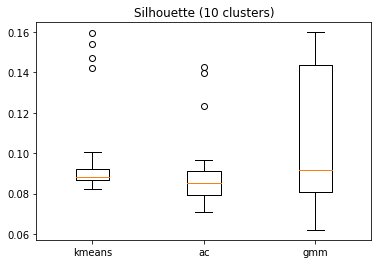

In [254]:
models_titles = [model[1] for model in models_list]
models_sil_lists = [silhoutte['none'][model][NUMBER_OF_CLUSTERS] for model in models_titles]

fig1, ax1 = plt.subplots()
ax1.set_xticklabels(models_titles)
ax1.set_title('Silhouette (10 clusters)')
ax1.boxplot(models_sil_lists)
plt.savefig('sil_10_clusters.svg', format='svg', dpi=1200)
plt.show()

In [33]:
#plot_silhoutte(mean_silhouette_by_num_clusters('none', 'gmm'))
#plot_silhoutte(mean_silhouette_by_num_clusters('none', 'kmeans'))

## MI 

In [239]:
#mi_data['none'][model][NUMBER_OF_CLUSTERS]['age']

<ipython-input-256-11c6d5173cc8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(models_titles + ['dbscan'])
<ipython-input-256-11c6d5173cc8>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(models_titles + ['dbscan'])


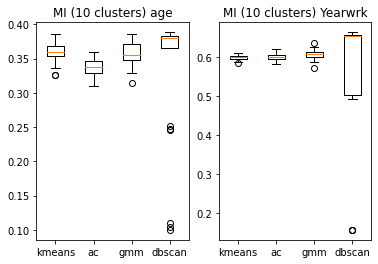

In [256]:
fig, ax = plt.subplots(ncols=2)

for i, var in enumerate(['age', 'Yearwrk']):
    models_titles = [model[1] for model in models_list]
    models_mi_lists = [mi_data['none'][model][NUMBER_OF_CLUSTERS][var] for model in models_titles] + \
        [mi_data['mca']['dbscan'][NUMBER_OF_CLUSTERS][var]]

    ax[i].set_xticklabels(models_titles + ['dbscan'])
    ax[i].set_title(f'MI (10 clusters) {var}')
    ax[i].boxplot(models_mi_lists)
plt.savefig('mi_10_clusters.svg', format='svg', dpi=1200)
plt.show()

In [34]:
mean_MI_by_num_clusters('none', 'kmeans', 'age')

[0.2777632009386349,
 0.38014591586350255,
 0.3743130835451256,
 0.3607789736663495,
 0.34514273109760524,
 0.3544917634476471,
 0.3581730008351523,
 0.3557376077570933,
 0.3592086694640802,
 0.36452413390312316,
 0.3632677847129538,
 0.3608070398455163,
 0.359004673513847]

## Visualization 

In [262]:
NUMBER_OF_CLUSTERS = 10

In [263]:
df_reduced_partial, df_partial, mca = sample_reduce(df, frac=0.01)

In [264]:
df_reduced_partial

,0,1,2,3,4,5,6,7
0,0.550306,-0.210481,0.038769,-0.012829,-0.042142,0.006202,0.014125,0.054716
1,0.432975,-0.090976,-0.155397,0.149566,0.050092,-0.045211,0.209540,-0.108151
2,-0.134450,0.189429,-0.039379,-0.167624,0.062623,-0.044564,-0.044055,0.077865
3,0.552478,-0.204425,0.017560,0.003626,-0.029086,0.007394,0.049439,0.044601
4,0.048630,0.459474,0.343946,0.213906,-0.038240,-0.090024,-0.022556,-0.208533
...,...,...,...,...,...,...,...,...
24578,-0.257352,-0.180520,-0.035376,-0.084475,0.017174,0.024891,0.010109,-0.010333
24579,-0.361224,-0.200140,0.344909,0.232367,-0.086817,-0.109166,-0.010279,0.055606
24580,-0.100632,0.089304,-0.035675,-0.022503,0.096308,-0.127083,-0.044983,0.112933
24581,-0.265849,-0.122014,-0.070240,-0.181211,0.007204,0.037461,-0.023600,-0.055918


In [265]:
df_partial

,dAncstry1_0,dAncstry1_1,dAncstry1_2,dAncstry1_3,dAncstry1_4,dAncstry1_5,dAncstry1_6,dAncstry1_7,dAncstry1_8,dAncstry1_9,...,iYearsch_11,iYearsch_12,iYearsch_13,iYearsch_14,iYearsch_15,iYearsch_16,iYearsch_17,dYrsserv_0,dYrsserv_1,dYrsserv_2
1390779,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1877283,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
894592,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1109251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
682990,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763400,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1515505,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1145161,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1189191,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [266]:
tsne = TSNE(n_components = 2)

tsne_result = tsne.fit_transform(df_partial)

In [446]:
plot_data = {
    'kmeans': {

    },
    'ac': {
        
    },
    'gmm': {
        
    },
    'dbscan': {
        
    }
}


for data, features in [(df_partial, 'none')]:
    print(f'with {features}')

    features_mat = data.to_numpy()

    for Clstr, name in [(KMeans, 'kmeans'), (AgglomerativeClustering, 'ac'), (GaussianMixture, 'gmm')]:
        print(f'{name}:')
        try:
            c = Clstr(n_clusters=NUMBER_OF_CLUSTERS).fit(features_mat)
            c_labels = c.labels_
        except:
            c = Clstr(n_components=NUMBER_OF_CLUSTERS).fit(features_mat)
            c_labels = c.predict(features_mat)
            
        plot_data[name]['labels'] = c_labels
        plot_data[name]['model'] = c

with none
kmeans:
ac:
gmm:


## DBscan - find eps 

In [447]:
!pip install kneed > /dev/null

You should consider upgrading via the '/home/maayan/anaconda3/envs/data-science/bin/python -m pip install --upgrade pip' command.


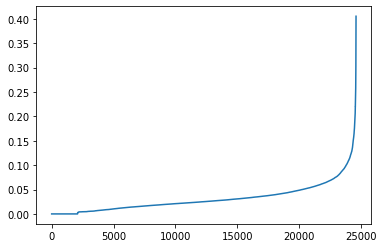

In [448]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_reduced_partial)
distances, indices = nbrs.kneighbors(df_reduced_partial)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.savefig('dbscan_elbow.svg', format='svg', dpi=1200)
plt.show()

In [449]:
from kneed import KneeLocator

dis_idx_y = [i for i in range(len(distances))]

kneedle = KneeLocator(x=distances, y=dis_idx_y, curve="convex", direction="increasing", S=1)

In [450]:
eps = 0.12
min_s = 80

In [451]:
plot_data['dbscan']['model'] = DBSCAN(eps=eps, min_samples=min_s)
clustering = plot_data['dbscan']['model'].fit(df_reduced_partial)
plot_data['dbscan']['labels'] = clustering.labels_
uniques = np.unique(plot_data['dbscan']['labels'], return_counts=True)
print(f'epsilon: {eps}, min samples: {min_s}, num of clusters: {len(uniques[0])}')
if len(uniques[0]) >= 4 and len(uniques[0]) <= 20:
    print(uniques)
print(uniques)
print('-'*10)

epsilon: 0.12, min samples: 80, num of clusters: 11
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([3505, 5150, 4700,  559, 7911,  764, 1175,  302,  118,  195,  204]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([3505, 5150, 4700,  559, 7911,  764, 1175,  302,  118,  195,  204]))
----------


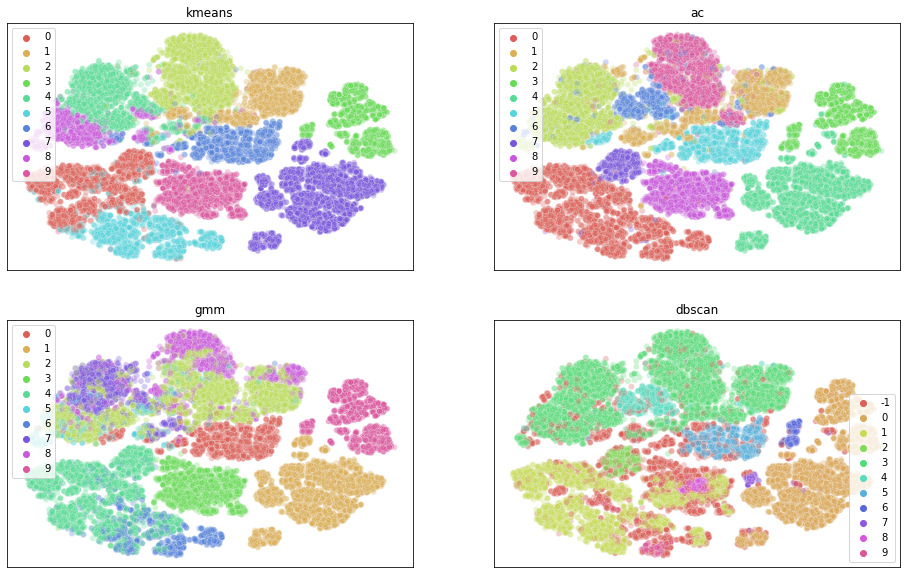

In [565]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16, 10))

s1 = sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=plot_data['kmeans']['labels'],
    palette=sns.color_palette("hls", NUMBER_OF_CLUSTERS),
    data=tsne_result,
    legend="full",
    alpha=0.3,
    ax=ax1,
    rasterized=True
)
s1.set_title('kmeans')

s2 = sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=plot_data['ac']['labels'],
    palette=sns.color_palette("hls", NUMBER_OF_CLUSTERS),
    data=tsne_result,
    legend="full",
    alpha=0.3,
    ax=ax2,
    rasterized=True
)
s2.set_title('ac')

s3 = sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=plot_data['gmm']['labels'],
    palette=sns.color_palette("hls", NUMBER_OF_CLUSTERS),
    data=tsne_result,
    legend="full",
    alpha=0.3,
    ax=ax3,
    rasterized=True
)
s3.set_title('gmm')

s4 = sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=plot_data['dbscan']['labels'],
    palette=sns.color_palette("hls", len(np.unique(plot_data['dbscan']['labels']))),
    data=tsne_result,
    legend="full",
    alpha=0.3,
    ax=ax4,
    rasterized=True
)
s4.set_title('dbscan')

for s in [s1, s2, s3, s4]:
    s.set(xticklabels=[], yticklabels=[], xlabel=None, ylabel=None)
    s.tick_params(bottom=False, left=False, right=False, top=False)
plt.savefig('data_dist.svg', format='svg', dpi=120)
plt.show()

In [453]:
labels = plot_data['dbscan']['labels']

for var, var_text in external_vars:
    subset_var = var[df_partial.index]
    mi_score = normalized_mutual_info_score(subset_var, labels)
    #silhouette_score(df_reduced_partial, labels)
    
    print(f'{var_text}: {mi_score}')
silhouette_score(df_reduced_partial, labels)

age: 0.324873846421107
hispanic: 0.029014877153766407
Yearwrk: 0.5445034472874706
sex: 0.06593646378332774


0.4275919079097594

In [454]:
for var, var_text in external_vars:
    subset_var = var[df_partial.index]
    subset_var = [y for i, y in enumerate(subset_var) if plot_data['dbscan']['labels'][i] != -1]
    labels = [y for y in plot_data['dbscan']['labels'] if y != -1]
    mi_score = normalized_mutual_info_score(subset_var, labels)
    
    print(f'{var_text}: {mi_score}')
    
labels = [y for y in plot_data['dbscan']['labels'] if y != -1]
idx_without_outliers = [True if y != -1 else False for y in plot_data['dbscan']['labels']]
    
silhouette_score(df_reduced_partial[idx_without_outliers], labels)

age: 0.38393358375274084
hispanic: 0.032623111672372224
Yearwrk: 0.656564462949166
sex: 0.0780141320373592


0.5779981620396171

## MI 

In [525]:
!pip install statsmodels > /dev/null

You should consider upgrading via the '/home/maayan/anaconda3/envs/data-science/bin/python -m pip install --upgrade pip' command.


Normalized MI - MI/((H(true)+H(pred))/2)

In [455]:
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [456]:
ttest_ind([1,2,3], [0,1,2])

Ttest_indResult(statistic=1.224744871391589, pvalue=0.2878641347266908)

In [457]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [458]:
MODELS = ['kmeans', 'ac', 'gmm']

for y_category in [ 'age',
                'hispanic',
                'Yearwrk',
                'sex']:
    algos = []
    for algo in MODELS:
        prep = 'none'
        if algo == 'dbscan':
            prep = 'mca'
        algos.append(mi_data[prep][algo][NUMBER_OF_CLUSTERS][y_category])
        print(f'{algo}, {y_category}')
        print(statistics.mean(mi_data[prep][algo][NUMBER_OF_CLUSTERS][y_category]))
    F_anova, p_anova = f_oneway(*algos[:-1])

    print('p_anova (without DBscan)', p_anova)
    groups = []
    
    for i, model in enumerate(MODELS):
        for _ in range(len(algos[i])):
            groups.append(model)
    
    assert len(flatten(algos)) == len(groups)
    print(pairwise_tukeyhsd(flatten(algos), groups))

    print('-'*60)
    print('-'*60)

kmeans, age
0.3592086694640802
ac, age
0.33769652003484946
gmm, age
0.35683790651685415
p_anova (without DBscan) 1.3736167423772802e-07
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
    ac    gmm   0.0191  0.001 0.0098 0.0285   True
    ac kmeans   0.0215  0.001 0.0122 0.0309   True
   gmm kmeans   0.0024 0.7989 -0.007 0.0117  False
--------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
kmeans, hispanic
0.01785705957662098
ac, hispanic
0.023419702493129208
gmm, hispanic
0.01869492074483931
p_anova (without DBscan) 0.0005068597005850031
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    ac    gmm  -0.0047 0.0053 -0.0082 -0.0012   True
    ac kmeans  -0.00

In [459]:
#[mean_silhouette('none', model[1], 10) for model in models_list]

_, p_value = f_oneway(*[silhoutte['none'][model[1]][NUMBER_OF_CLUSTERS] for model in models_list])
print(p_value)

0.030069510322281487


In [460]:
MODELS

['kmeans', 'ac', 'gmm']

In [461]:
algos_sil = []
for algo in MODELS:
    algos_sil.append(silhoutte['none'][algo][NUMBER_OF_CLUSTERS])
F_anova, p_anova = f_oneway(*algos_sil)

print('p_anova', p_anova)
groups = []

for i, model in enumerate(MODELS):
    for _ in range(len(algos_sil[i])):
        groups.append(model)

assert len(flatten(algos_sil)) == len(groups)
print(pairwise_tukeyhsd(flatten(algos_sil), groups))

p_anova 0.030069510322281487
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    ac    gmm   0.0173 0.0224   0.002 0.0326   True
    ac kmeans   0.0082 0.4123 -0.0071 0.0235  False
   gmm kmeans  -0.0091 0.3352 -0.0244 0.0062  False
---------------------------------------------------


In [462]:
statistics.mean(mi_data['none']['kmeans'][NUMBER_OF_CLUSTERS]['age'])

0.3592086694640802

In [463]:
statistics.mean(mi_data['none']['ac'][NUMBER_OF_CLUSTERS]['age'])

0.33769652003484946

In [464]:
statistics.mean(mi_data['none']['gmm'][NUMBER_OF_CLUSTERS]['age'])

0.35683790651685415

## Anomaly detection 

In [557]:
from sklearn.neighbors import LocalOutlierFactor


anomaly_clf = AutoEncoder(epochs=20, preprocessing=True, hidden_neurons=[64, 32, 32, 64])#LocalOutlierFactor(n_neighbors=20, leaf_size=60)
anomaly_detection_results = anomaly_clf.fit_predict(df_partial)
anomalies_filter = [True if f != 1 else False for f in anomaly_detection_results]

/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_351 (Dense)            (None, 367)               135056    
_________________________________________________________________
dropout_300 (Dropout)        (None, 367)               0         
_________________________________________________________________
dense_352 (Dense)            (None, 367)               135056    
_________________________________________________________________
dropout_301 (Dropout)        (None, 367)               0         
_________________________________________________________________
dense_353 (Dense)            (None, 64)                23552     
_________________________________________________________________
dropout_302 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_354 (Dense)            (None, 32)              

In [558]:
np.unique(anomaly_detection_results, return_counts=True)

(array([0, 1]), array([22124,  2459]))

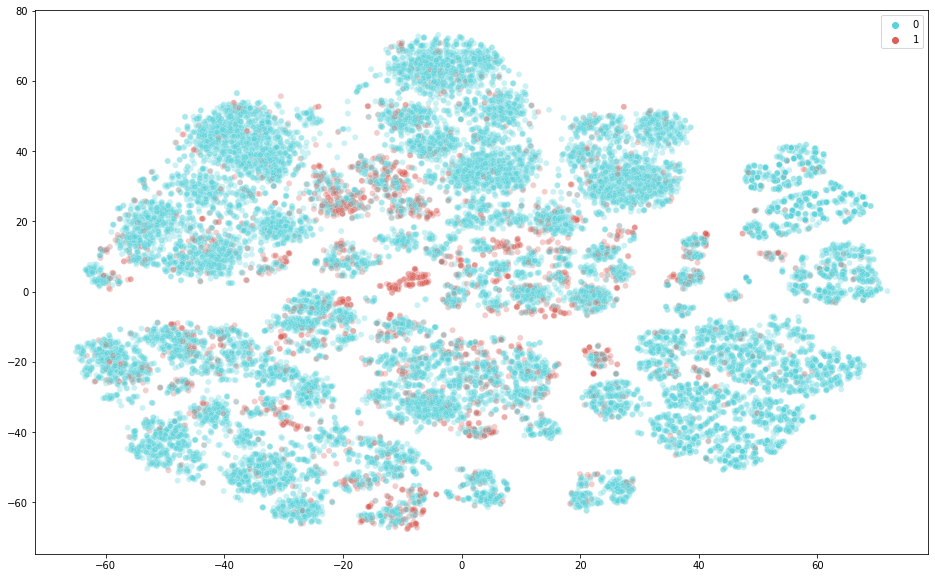

In [564]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=anomaly_detection_results,
    palette=sns.color_palette("hls", 2)[::-1],
    data=tsne_result,
    legend="full",
    alpha=0.3,
    rasterized=True    
)

plt.savefig('anomalies_dist.svg', format='svg', dpi=150)
plt.show()

In [537]:
for y_category, y_name in external_vars:
    print(y_name)
    print(normalized_mutual_info_score(anomaly_detection_results, y_category[df_partial.index]))

age
0.003534441866638979
hispanic
0.03284789325736041
Yearwrk
0.0049352720215892
sex
0.005653992161737026


In [538]:
no_anomalies_data = {
    'kmeans': {

    },
    'ac': {
        
    },
    'gmm': {
        
    },
}


for data, features in [(df_partial, 'none')]:
    print(f'with {features}')

    features_mat = data[anomalies_filter].to_numpy()

    for Clstr, name in [(KMeans, 'kmeans'), (AgglomerativeClustering, 'ac'), (GaussianMixture, 'gmm')]:
        print(f'{name}:')
        try:
            c = Clstr(n_clusters=NUMBER_OF_CLUSTERS).fit(features_mat)
            c_labels = c.labels_
        except:
            c = Clstr(n_components=NUMBER_OF_CLUSTERS).fit(features_mat)
            c_labels = c.predict(features_mat)
            
        no_anomalies_data[name]['labels'] = c_labels
        no_anomalies_data[name]['model'] = c

with none
kmeans:
ac:
gmm:


In [539]:
for algo in no_anomalies_data.keys():
    print(algo)
    labels = no_anomalies_data[algo]['labels']
    for y_category, y_name in external_vars:
        print(y_name)
        print(normalized_mutual_info_score(labels, y_category[df_partial.index][anomalies_filter]))

kmeans
age
0.3723698854810254
hispanic
0.004252950922080393
Yearwrk
0.61612909185124
sex
0.06958149049917679
ac
age
0.3654436766393769
hispanic
0.00607810201458277
Yearwrk
0.6063062398644482
sex
0.06630749418534718
gmm
age
0.3601496647850295
hispanic
0.005727888328078211
Yearwrk
0.6025556731453272
sex
0.04074019248624823


In [542]:
silhoutte_no_anomalies = {
    'mca': defaultdict(lambda: defaultdict(list)),
    'none': defaultdict(lambda: defaultdict(list))
}

mi_data_no_anomalies = {
    'mca': defaultdict(lambda: defaultdict(lambda: defaultdict(list))),
    'none': defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
}

mi_data_anomalies_vars = defaultdict(list)


i = NUMBER_OF_CLUSTERS
print(f'Number of clusters {i}')
n_samples = 30

for sample_num in range(n_samples):
    _, df_partial2, mca_2 = sample_reduce(df, frac=0.001)
    idx = df_partial2.index
    for data, features in [(df_partial2, 'none')]:
        
        anomaly_clf = AutoEncoder(epochs=30, preprocessing=True, hidden_neurons=[64, 32, 32, 64], verbose=0)#LocalOutlierFactor(n_neighbors=5, leaf_size=10)
        anomaly_detection_results = anomaly_clf.fit_predict(data)
        print(np.unique(anomaly_detection_results, return_counts=True))
        anomalies_filter = [True if f != 1 else False for f in anomaly_detection_results]
        
        print(f'with {features}')

        features_mat = data[anomalies_filter].to_numpy()

        for Clstr, name in models_list:
            print(f'{name}:')
            try:
                ac = Clstr(n_clusters=i).fit(features_mat)
                ac_labels = ac.labels_
            except:
                ac = Clstr(n_components=i).fit(features_mat)
                ac_labels = ac.predict(features_mat)

            silhouette_avg = silhouette_score(features_mat, ac_labels)
            silhoutte_no_anomalies[features][name][i].append(silhouette_avg)
            print(
                        "For n_clusters =",
                        i,
                        "The average silhouette_score is :",
                        silhouette_avg,
                )
            unique_counts = np.unique(ac_labels,return_counts=True)
            print(unique_counts)

            for var, var_text in external_vars:
                subset_var = var[idx]
                mi_score = normalized_mutual_info_score(subset_var[anomalies_filter], ac_labels)
                print(f'{var_text}: {mi_score}')
                mi_data_no_anomalies[features][name][i][var_text].append(mi_score)
        for var, var_text in external_vars:
            subset_var = var[idx]
            mi_data_anomalies_vars[var_text].append(
                normalized_mutual_info_score(anomaly_detection_results, subset_var)
            )
            print('-'*10)
    print('-'*20)

Number of clusters 10


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.15835379976272687
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 64, 528, 176, 274, 164, 193, 202, 264, 140, 207]))
age: 0.36948730837380506
hispanic: 0.029833859179224008
Yearwrk: 0.6072516329186116
sex: 0.0607514158790773
ac:
For n_clusters = 10 The average silhouette_score is : 0.10266508633638546
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([419, 290, 281, 183, 346, 126,  72, 175, 255,  65]))
age: 0.34348548561626885
hispanic: 0.02775283225061197
Yearwrk: 0.5975396191673876
sex: 0.06884602773088278
gmm:
For n_clusters = 10 The average silhouette_score is : 0.1434076019260056
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([326, 528, 178, 238,  74, 262, 188, 192, 133,  93]))
age: 0.367257924080474
hispanic: 0.018396991155946354
Yearwrk: 0.6141091816765504
sex: 0.15983433427301702
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09023462561446678
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([190, 351, 200, 206, 310, 167, 275, 203, 175, 135]))
age: 0.36502985855987913
hispanic: 0.013798032510291372
Yearwrk: 0.5960621089074494
sex: 0.05247377112275466
ac:
For n_clusters = 10 The average silhouette_score is : 0.07958283360006498
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([332, 179,  99, 270, 377, 271, 118, 172, 253, 141]))
age: 0.35600369662325426
hispanic: 0.01328675800957589
Yearwrk: 0.5852361363217543
sex: 0.07174924634619742
gmm:
For n_clusters = 10 The average silhouette_score is : 0.07808241158608391
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([351, 289, 121, 135, 357, 191, 152, 167, 209, 240]))
age: 0.36149943271816787
hispanic: 0.013992751907538674
Yearwrk: 0.6083131285940183
sex: 0.12396791655001885
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.08741084519599689
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([104, 182, 253, 378, 375, 300, 120, 128, 193, 179]))
age: 0.38615387847713417
hispanic: 0.016733185191016575
Yearwrk: 0.619444784260938
sex: 0.05498944385315667
ac:
For n_clusters = 10 The average silhouette_score is : 0.07164722532877335
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([427, 290, 394, 162, 156, 285,  70, 164, 100, 164]))
age: 0.3541619810735417
hispanic: 0.013233018714238763
Yearwrk: 0.6110337655384317
sex: 0.07645620170055556
gmm:
For n_clusters = 10 The average silhouette_score is : 0.1109817208416477
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([182, 167, 131, 500, 111, 229, 170, 375, 168, 179]))
age: 0.3517487028456452
hispanic: 0.016033615052321783
Yearwrk: 0.6086480492565762
sex: 0.12787980196938759
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.0923606105066177
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([217, 332, 227, 388,  82, 186, 149, 165, 280, 186]))
age: 0.3413357096401117
hispanic: 0.014594821911791
Yearwrk: 0.5819325190419223
sex: 0.09278540140619698
ac:
For n_clusters = 10 The average silhouette_score is : 0.07795186863400094
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([377, 257, 270, 188, 218, 352,  73, 129, 145, 203]))
age: 0.3533531309354646
hispanic: 0.013969798493263672
Yearwrk: 0.5965120981311991
sex: 0.07181590928047611
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08702813037061123
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([171, 306, 322, 332, 158, 165,  66, 182, 205, 305]))
age: 0.3634958596170406
hispanic: 0.01632844587452815
Yearwrk: 0.6057456903537102
sex: 0.05418319741889135
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09403698253746196
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([142,  68, 190, 226, 171, 165, 303, 269, 335, 343]))
age: 0.37792069704548
hispanic: 0.01309628003479604
Yearwrk: 0.6020058444843875
sex: 0.05502678180612493
ac:
For n_clusters = 10 The average silhouette_score is : 0.09686762017656024
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([299, 383,  81, 275, 306, 169, 138, 166,  63, 332]))
age: 0.37691618098145097
hispanic: 0.013508933747053474
Yearwrk: 0.6051811524449605
sex: 0.06774868555233254
gmm:
For n_clusters = 10 The average silhouette_score is : 0.15150001634227012
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 82, 539, 204, 155,  93, 332, 184, 172, 238, 213]))
age: 0.3663622596004616
hispanic: 0.013763327053418933
Yearwrk: 0.6236512188618433
sex: 0.11875380127948414
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09435554760880584
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([263, 205, 145, 364, 203, 289, 168, 225, 141, 209]))
age: 0.3842349608020155
hispanic: 0.016544296514294832
Yearwrk: 0.6019932194511894
sex: 0.05519558106835931
ac:
For n_clusters = 10 The average silhouette_score is : 0.07695167979205345
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([222, 273, 379, 330, 186, 240, 172, 153, 189,  68]))
age: 0.33870838259112684
hispanic: 0.023220843658073042
Yearwrk: 0.5896092064962476
sex: 0.058217949362731315
gmm:
For n_clusters = 10 The average silhouette_score is : 0.09273369265983795
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([283, 364, 228, 198, 265, 139,  66, 168, 344, 157]))
age: 0.35370256107144965
hispanic: 0.01667324259460016
Yearwrk: 0.6097351527846507
sex: 0.06962236618947937
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.10705770749245526
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([126, 172, 399, 248, 276, 364,  81, 209, 178, 159]))
age: 0.36499682975580916
hispanic: 0.012909709630078854
Yearwrk: 0.5951880750403967
sex: 0.08116417709130902
ac:
For n_clusters = 10 The average silhouette_score is : 0.0818148904192237
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([240, 399, 235, 184, 170, 258, 381, 122, 155,  68]))
age: 0.34562625527270896
hispanic: 0.015516378388663054
Yearwrk: 0.6099878466032089
sex: 0.06761162637331006
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08977008488549465
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([160, 172, 308, 127, 247, 164, 209, 275, 364, 186]))
age: 0.37623348738749474
hispanic: 0.014410571738231381
Yearwrk: 0.603133501033194
sex: 0.0577880552488714
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.16443737032172176
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([131, 541, 242,  89, 251, 184, 333, 156, 192,  93]))
age: 0.35012387225226044
hispanic: 0.015583942959855655
Yearwrk: 0.6106846722729654
sex: 0.08524774348580837
ac:
For n_clusters = 10 The average silhouette_score is : 0.07912962687757723
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([319, 370, 270, 188, 391,  97, 120, 149, 147, 161]))
age: 0.35496342294514344
hispanic: 0.015845884148647654
Yearwrk: 0.6016527136434661
sex: 0.06688408925591278
gmm:
For n_clusters = 10 The average silhouette_score is : 0.0860722764404934
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([212,  60, 162, 261, 170, 278, 132, 206, 378, 353]))
age: 0.3845122025845938
hispanic: 0.0175033993258114
Yearwrk: 0.6216308594968256
sex: 0.06438294953537091
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.10586041563161232
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([356,  59, 303,  85, 162, 358, 379, 178, 202, 130]))
age: 0.37970796636659254
hispanic: 0.010536543437997762
Yearwrk: 0.6049534637435631
sex: 0.0670734879671873
ac:
For n_clusters = 10 The average silhouette_score is : 0.0891098603337667
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([406, 364, 400, 182, 133, 265,  69,  72, 151, 170]))
age: 0.3473425875525377
hispanic: 0.02578865643951835
Yearwrk: 0.6176637256183034
sex: 0.05815592395509508
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08229472890111293
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([319, 276, 169,  92, 158,  85, 113, 674, 164, 162]))
age: 0.3963781413386204
hispanic: 0.015853165644314795
Yearwrk: 0.633137218521304
sex: 0.05569544938466244
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09128053699249941
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([257, 297, 173, 175, 151, 223, 368, 208, 205, 155]))
age: 0.35772578280692124
hispanic: 0.012972427664850178
Yearwrk: 0.6015072281022225
sex: 0.07938971316190287
ac:
For n_clusters = 10 The average silhouette_score is : 0.08654774994079531
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([430, 356, 421, 173, 128, 151, 185, 141,  51, 176]))
age: 0.37252502586903535
hispanic: 0.012162124886292884
Yearwrk: 0.6171097094055005
sex: 0.07887813743237176
gmm:
For n_clusters = 10 The average silhouette_score is : 0.1558070237550433
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([100, 541, 330, 143, 140, 150, 213, 216, 204, 175]))
age: 0.3838308462088103
hispanic: 0.01430330309988879
Yearwrk: 0.6238891094246019
sex: 0.08856832928852015
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09349420520318559
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([186, 371, 280, 232, 218, 117, 190, 271, 195, 152]))
age: 0.3933620189829414
hispanic: 0.013358598290432674
Yearwrk: 0.5994674284922474
sex: 0.06308706497425198
ac:
For n_clusters = 10 The average silhouette_score is : 0.08344607009461211
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([359, 246, 294, 191, 219, 201, 347, 115, 166,  74]))
age: 0.34871479162677704
hispanic: 0.013052251690319564
Yearwrk: 0.5969661317111115
sex: 0.08927018334486662
gmm:
For n_clusters = 10 The average silhouette_score is : 0.10536101845204814
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([488, 282, 295,  48, 148, 186, 163, 176, 231, 195]))
age: 0.3599577260455753
hispanic: 0.018238888041605505
Yearwrk: 0.5996282849464303
sex: 0.05700932118731939
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09141233402769679
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([171, 210, 164, 285, 209, 384, 184, 118, 265, 222]))
age: 0.3843478126124027
hispanic: 0.014081015014053977
Yearwrk: 0.6041369848942156
sex: 0.06554656822867133
ac:
For n_clusters = 10 The average silhouette_score is : 0.08459752333397155
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([381, 374, 277, 184, 146, 256, 193, 181,  58, 162]))
age: 0.3729621400775126
hispanic: 0.016577793243783716
Yearwrk: 0.6109910676541019
sex: 0.062271471950292236
gmm:
For n_clusters = 10 The average silhouette_score is : 0.1617324938302549
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([171, 264, 336, 555, 118,  74, 210, 171, 110, 203]))
age: 0.38240534186243214
hispanic: 0.016396664232426916
Yearwrk: 0.6254692257169954
sex: 0.06662952770382444
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09300653843185319
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([277, 398, 188, 225, 194, 111, 227, 148, 260, 184]))
age: 0.38031894543655514
hispanic: 0.014603500524241357
Yearwrk: 0.6113439930739885
sex: 0.10256482489941628
ac:
For n_clusters = 10 The average silhouette_score is : 0.09053942157695051
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([384, 291, 351, 200, 203, 379,  76, 169,  57, 102]))
age: 0.35193597565503226
hispanic: 0.025669818269345814
Yearwrk: 0.6246521523428878
sex: 0.07431742895650505
gmm:
For n_clusters = 10 The average silhouette_score is : 0.09081666675768485
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 38, 377, 269, 198, 384, 179, 195, 246, 160, 166]))
age: 0.38577551083864997
hispanic: 0.015899983971318695
Yearwrk: 0.6208795344876623
sex: 0.1379656961728068
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.0925395033971548
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([359, 206, 263, 132, 184, 309, 153, 190, 258, 158]))
age: 0.3734701724217481
hispanic: 0.017153084345230628
Yearwrk: 0.6061116461898836
sex: 0.05537141825898476
ac:
For n_clusters = 10 The average silhouette_score is : 0.08073852657591431
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([354, 272,  64, 299, 195, 134, 344, 192, 215, 143]))
age: 0.37269220920367324
hispanic: 0.01489571972483078
Yearwrk: 0.6040040630499316
sex: 0.07992554302164642
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08306465133930023
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([134, 359, 151, 153, 190, 346, 171, 180, 370, 158]))
age: 0.3650982188815917
hispanic: 0.020794498392817967
Yearwrk: 0.6178419258742328
sex: 0.09892715711235048
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09909151169479925
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([240, 169, 184, 184, 116, 138, 294, 378, 351, 158]))
age: 0.36769365876807697
hispanic: 0.01597424444142172
Yearwrk: 0.5940811118788162
sex: 0.10590160483084352
ac:
For n_clusters = 10 The average silhouette_score is : 0.08633284949425561
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([218, 242, 333, 306, 339, 141,  63, 186, 182, 202]))
age: 0.33779499952605935
hispanic: 0.018546386996299076
Yearwrk: 0.6020610191767961
sex: 0.07139943347240114
gmm:
For n_clusters = 10 The average silhouette_score is : 0.06141978249724666
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([120, 273, 270, 219, 286, 151, 230, 190, 249, 224]))
age: 0.3544280110490347
hispanic: 0.016322121275338667
Yearwrk: 0.5999286347437484
sex: 0.22844430025305057
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.099575059206581
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 83, 187, 244, 296, 175, 248, 412,  78, 313, 176]))
age: 0.3728979286142002
hispanic: 0.018394259087075617
Yearwrk: 0.6206471611458765
sex: 0.07218275240392218
ac:
For n_clusters = 10 The average silhouette_score is : 0.08757811031455096
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([216, 339, 267, 288, 183, 202, 397, 166,  96,  58]))
age: 0.36799991163251555
hispanic: 0.017485299229229305
Yearwrk: 0.6167911236916024
sex: 0.06674543105989585
gmm:
For n_clusters = 10 The average silhouette_score is : 0.11201759022672775
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([135,  72, 464, 187, 223, 138, 369, 231, 211, 182]))
age: 0.3960651721474516
hispanic: 0.01822545834487192
Yearwrk: 0.6141295405088784
sex: 0.09338462890042747
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09589538441482297
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([263, 197, 127, 136, 253, 196, 214, 380, 251, 195]))
age: 0.3856533904768396
hispanic: 0.01643893457671982
Yearwrk: 0.607994709381025
sex: 0.059253315131134424
ac:
For n_clusters = 10 The average silhouette_score is : 0.08526953590537124
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([307, 287, 379, 179, 337,  83, 199, 221,  57, 163]))
age: 0.3610374307233018
hispanic: 0.021407630568002635
Yearwrk: 0.6045016433694735
sex: 0.05601259295538246
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08909164982844368
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([193, 380, 350, 162, 273, 128,  52, 197, 196, 281]))
age: 0.37224675049015565
hispanic: 0.023850505580482594
Yearwrk: 0.626080215383571
sex: 0.1527852869104729
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09782563079209396
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 88, 336, 377, 196, 155, 232, 253, 169, 230, 176]))
age: 0.38923797542109057
hispanic: 0.015207401601426015
Yearwrk: 0.6077346333983624
sex: 0.05253863381829555
ac:
For n_clusters = 10 The average silhouette_score is : 0.08592590409890809
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([271, 310, 390, 199, 253, 281,  82, 114, 163, 149]))
age: 0.36753446538628126
hispanic: 0.01778874394292723
Yearwrk: 0.6164645842535004
sex: 0.062206355239357206
gmm:
For n_clusters = 10 The average silhouette_score is : 0.09333910797559443
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([241, 206, 376, 327,  89, 305, 100, 196, 176, 196]))
age: 0.36950525017793984
hispanic: 0.015092584684078673
Yearwrk: 0.6058661872899131
sex: 0.11032664886209237
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.16284141062930593
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([137, 501, 126, 193,  94, 141, 234, 223, 299, 264]))
age: 0.36987938215186184
hispanic: 0.015232422417341865
Yearwrk: 0.6079764029301082
sex: 0.10605573856640245
ac:
For n_clusters = 10 The average silhouette_score is : 0.08800670143376128
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([427, 289, 389, 199, 350,  78, 124, 151, 151,  54]))
age: 0.3390475053163517
hispanic: 0.024371079736731253
Yearwrk: 0.6085455177278395
sex: 0.08828865818801299
gmm:
For n_clusters = 10 The average silhouette_score is : 0.07471401995131641
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([195, 104, 164, 291, 292, 205, 209, 113, 302, 337]))
age: 0.3553493140460594
hispanic: 0.017082976806656835
Yearwrk: 0.6148090789434617
sex: 0.18188804434594097
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.0938904231049706
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([204, 129, 186, 366, 171, 198, 296, 183, 269, 210]))
age: 0.37398197310180986
hispanic: 0.017179671453482107
Yearwrk: 0.6039114829587812
sex: 0.06576100254936083
ac:
For n_clusters = 10 The average silhouette_score is : 0.08682731064549891
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([250, 345, 204, 244, 198, 122, 348, 202, 241,  58]))
age: 0.35585898753807305
hispanic: 0.02645000425497636
Yearwrk: 0.6084892518323635
sex: 0.05383119236027303
gmm:
For n_clusters = 10 The average silhouette_score is : 0.07626000335276158
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([117, 281, 186, 156, 238, 109, 170, 369, 274, 312]))
age: 0.3749730128578269
hispanic: 0.01590897624581764
Yearwrk: 0.5928825389220905
sex: 0.14054784601007184
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09365933890160388
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 73, 407, 187, 216, 170, 379, 240, 131, 245, 164]))
age: 0.37865136113102765
hispanic: 0.014860866237477375
Yearwrk: 0.6075864872974918
sex: 0.07423810126641532
ac:
For n_clusters = 10 The average silhouette_score is : 0.08529560489489924
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([378, 217, 424, 189, 373, 120, 229, 147,  80,  55]))
age: 0.3631548193016726
hispanic: 0.018611898204847075
Yearwrk: 0.6268236056829679
sex: 0.07113725078828619
gmm:
For n_clusters = 10 The average silhouette_score is : 0.16233231024387354
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 73, 316, 571,  91, 139, 248, 197, 203, 172, 202]))
age: 0.36805319348130644
hispanic: 0.015037816670646005
Yearwrk: 0.6208796189828905
sex: 0.05979631541372868
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09533396325892243
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([206, 274, 351, 185, 330, 159, 195, 168,  84, 260]))
age: 0.3845217932894637
hispanic: 0.014498150565697603
Yearwrk: 0.6039848987418359
sex: 0.07125494087756168
ac:
For n_clusters = 10 The average silhouette_score is : 0.08508079953428573
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([275, 342, 218, 165, 367,  86, 294, 169, 115, 181]))
age: 0.34822515495770145
hispanic: 0.01543897030708423
Yearwrk: 0.6009558937677048
sex: 0.07641221851502837
gmm:
For n_clusters = 10 The average silhouette_score is : 0.09156882521910814
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([219,  90, 351, 171, 379, 196, 214, 224, 185, 183]))
age: 0.3626159630436502
hispanic: 0.01842589087529335
Yearwrk: 0.6032334023391718
sex: 0.14376347997295766
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09335097454523228
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([286, 337, 207, 276, 186, 214, 184, 175, 150, 197]))
age: 0.3699588726729371
hispanic: 0.013480917326930995
Yearwrk: 0.5937663089618044
sex: 0.06184020901184929
ac:
For n_clusters = 10 The average silhouette_score is : 0.09122287577830748
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([422, 300, 369, 195, 352, 149, 159,  65,  63, 138]))
age: 0.33199774590456815
hispanic: 0.01924048983192429
Yearwrk: 0.6074307998503023
sex: 0.07250196070384188
gmm:
For n_clusters = 10 The average silhouette_score is : 0.09110472493085181
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([391, 175, 185, 287, 152, 191,  97, 338, 245, 151]))
age: 0.3529801334264182
hispanic: 0.013880923070972015
Yearwrk: 0.6078179542778087
sex: 0.08878037244486149
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09434475845570804
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 84, 294, 369, 351, 186, 168, 144, 193, 178, 245]))
age: 0.36840724325497787
hispanic: 0.012502623036586294
Yearwrk: 0.5946874355554242
sex: 0.07919202824294581
ac:
For n_clusters = 10 The average silhouette_score is : 0.07952575013156214
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([398, 352, 172, 268, 265, 141,  68, 185, 198, 165]))
age: 0.36735586582737023
hispanic: 0.013037115739434462
Yearwrk: 0.6049070167245879
sex: 0.07247277503444711
gmm:
For n_clusters = 10 The average silhouette_score is : 0.07903283602878676
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([158, 168, 228, 152, 303, 122, 354, 202, 156, 369]))
age: 0.3838822439839726
hispanic: 0.014027450261219815
Yearwrk: 0.6054430202555267
sex: 0.09764134198443468
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09147405182450288
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([166, 183, 268, 230, 183, 201, 362, 181, 290, 148]))
age: 0.3841193263354545
hispanic: 0.01372711332017185
Yearwrk: 0.6095116848840855
sex: 0.0540197522439317
ac:
For n_clusters = 10 The average silhouette_score is : 0.07846274039745413
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([443, 227, 277, 178, 373, 144, 172, 154, 191,  53]))
age: 0.3560646701002049
hispanic: 0.013829824836769299
Yearwrk: 0.6192583548310766
sex: 0.06542703112173266
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08471514395899593
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([419, 145, 409, 250, 154, 232, 125, 236,  76, 166]))
age: 0.3403673237834547
hispanic: 0.01798628378457104
Yearwrk: 0.6077076881228044
sex: 0.1313256460103105
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.08875980944298675
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([263, 208, 170, 173, 259, 159, 355, 176, 180, 269]))
age: 0.36839928387138654
hispanic: 0.014421155306338538
Yearwrk: 0.5934886357835512
sex: 0.06164967984549681
ac:
For n_clusters = 10 The average silhouette_score is : 0.07611468809269728
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([257, 153, 295, 165, 289, 260,  68, 153, 200, 372]))
age: 0.3388980679028046
hispanic: 0.017703195761657242
Yearwrk: 0.5947971219297916
sex: 0.07962962443777774
gmm:
For n_clusters = 10 The average silhouette_score is : 0.09103797517803332
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([157, 170, 147, 248, 321, 355, 263,  81, 307, 163]))
age: 0.37168966079300614
hispanic: 0.01538708615002686
Yearwrk: 0.6031956885129258
sex: 0.12956143937183068
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09096167772141675
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([206, 355, 322,  74, 223, 176, 268, 179, 239, 170]))
age: 0.35738186033259745
hispanic: 0.014814651177142368
Yearwrk: 0.5996679935042959
sex: 0.10282691560451089
ac:
For n_clusters = 10 The average silhouette_score is : 0.08919518010193511
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([419, 244, 367, 187, 198, 271, 137, 157,  58, 174]))
age: 0.34370429296141075
hispanic: 0.016130429041039566
Yearwrk: 0.603035198612536
sex: 0.07049608409877929
gmm:
For n_clusters = 10 The average silhouette_score is : 0.15495728516603766
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([220, 525, 221, 253,  74, 178, 223, 188, 194, 136]))
age: 0.35988458359814307
hispanic: 0.012601418410692872
Yearwrk: 0.6068129673045108
sex: 0.18620706485120983
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09176060965141637
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([216, 232, 377, 190, 122, 247, 181, 213, 254, 180]))
age: 0.3735061493945504
hispanic: 0.01614357331068846
Yearwrk: 0.6070110292818919
sex: 0.055169077801059285
ac:
For n_clusters = 10 The average silhouette_score is : 0.098269433113054
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([417, 360, 236, 206, 188,  71, 226, 197, 117, 194]))
age: 0.35673295443437064
hispanic: 0.015504469461362214
Yearwrk: 0.6054311740412639
sex: 0.07212734560664696
gmm:
For n_clusters = 10 The average silhouette_score is : 0.15650855328725066
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([557, 182, 179,  76, 178, 253, 222, 216, 226, 123]))
age: 0.36961247765276767
hispanic: 0.016964972231313935
Yearwrk: 0.6596417054751901
sex: 0.059657679330656035
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.0943323840556382
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([216, 362,  70, 311, 207, 216, 180, 196, 182, 272]))
age: 0.38656602370276855
hispanic: 0.014355380553413417
Yearwrk: 0.6213222148776799
sex: 0.0536307541696003
ac:
For n_clusters = 10 The average silhouette_score is : 0.09399626164685358
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([399, 394, 219, 180, 177, 263, 338,  59,  75, 108]))
age: 0.34760949903998045
hispanic: 0.027830615287991408
Yearwrk: 0.6112217481767653
sex: 0.05929999101484002
gmm:
For n_clusters = 10 The average silhouette_score is : 0.11294344548737915
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([458, 103, 162, 363, 118, 180, 268, 196, 197, 167]))
age: 0.3557915206220601
hispanic: 0.016170276382653476
Yearwrk: 0.6025061292076198
sex: 0.10795033529874237
----------
----------
----------
----------
--------------------


/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([2212,  246]))
with none
kmeans:
For n_clusters = 10 The average silhouette_score is : 0.09891524990805617
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 74, 231, 184, 354, 198, 367, 116, 156, 236, 296]))
age: 0.3781924522792398
hispanic: 0.01186849383427076
Yearwrk: 0.6079922262771293
sex: 0.07514150529909301
ac:
For n_clusters = 10 The average silhouette_score is : 0.08565026455594868
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([335, 310, 282, 345, 235, 206, 167, 174, 102,  56]))
age: 0.3502475816777272
hispanic: 0.014507591758330466
Yearwrk: 0.6000863299155016
sex: 0.06736339505516356
gmm:
For n_clusters = 10 The average silhouette_score is : 0.08359687137350577
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([365, 184, 133, 431, 367, 199,  89, 117,  58, 269]))
age: 0.36739465232623086
hispanic: 0.014039432268844984
Yearwrk: 0.6320176349053555
sex: 0.20377758685701347
----------
----------
----------
----------
--------------------


In [543]:
for model in MODELS:
    print(f'model: {model}')
    for _, var_text in external_vars:
        #print(y_var_name)
        mi_score_no_anomalies, mi_score_with_anomalies = mi_data_no_anomalies[features][model][NUMBER_OF_CLUSTERS][var_text], mi_data[features][model][NUMBER_OF_CLUSTERS][var_text]
        print(var_text)
        print(f'without anomalies {statistics.mean(mi_score_no_anomalies)}, with anomalies {statistics.mean(mi_score_with_anomalies)}')
        print(ttest_ind(mi_score_no_anomalies, mi_score_with_anomalies))
        #ttest_ind()
        print('-'*10)
    silhoutte_score_no_anomalies, silhoutte_score_with_anomalies = silhoutte_no_anomalies[features][model][NUMBER_OF_CLUSTERS], silhoutte[features][model][NUMBER_OF_CLUSTERS]
    print()
    print('silhoutte')
    print(f'without anomalies: {statistics.mean(silhoutte_score_no_anomalies)}, with anomalies: {statistics.mean(silhoutte_score_with_anomalies)}')
    print(ttest_ind(silhoutte_score_no_anomalies, silhoutte_score_with_anomalies))

    print('-'*20)
    print()

model: kmeans
age
without anomalies 0.3739088162777313, with anomalies 0.3592086694640802
Ttest_indResult(statistic=4.173239737615724, pvalue=0.00010188053477171649)
----------
hispanic
without anomalies 0.015163305181811323, with anomalies 0.01785705957662098
Ttest_indResult(statistic=-2.050093205535112, pvalue=0.044884882105169846)
----------
Yearwrk
without anomalies 0.6041149339244046, with anomalies 0.599554903167632
Ttest_indResult(statistic=2.2887324450050803, pvalue=0.02575555203822117)
----------
sex
without anomalies 0.0707107801621875, with anomalies 0.08501430714574444
Ttest_indResult(statistic=-2.6617493643836276, pvalue=0.010040696754132413)
----------

silhoutte
without anomalies: 0.10126177534441042, with anomalies: 0.09691943979327709
Ttest_indResult(statistic=0.7829575640754085, pvalue=0.43683735094904375)
--------------------

model: ac
age
without anomalies 0.3540885072751307, with anomalies 0.33769652003484946
Ttest_indResult(statistic=5.19365985840228, pvalue=2.77

In [544]:
#mi_data_anomalies_vars

In [545]:
#mi_data_anomalies_vars['sex']

In [566]:

for _, var_text in external_vars:
    #print(mi_data_anomalies_vars[model][var_text])
    print(f'anomalies MI with {var_text}: {statistics.mean(mi_data_anomalies_vars[var_text])}')
#     print(ttest_ind(mi_data_anomalies_vars[var_text],
#                     [0]*len(mi_data_anomalies_vars[var_text])))

anomalies MI with age: 0.005095387342424743
anomalies MI with hispanic: 0.03607891197922541
anomalies MI with Yearwrk: 0.006799789680651259
anomalies MI with sex: 0.004447862968958138


In [338]:
anomaly_detection_results.shape

(24583,)

In [339]:
y_category.shape

(2458285,)

In [353]:
!pip install pyod > /dev/null

You should consider upgrading via the '/home/maayan/anaconda3/envs/data-science/bin/python -m pip install --upgrade pip' command.


In [523]:
from pyod.models.auto_encoder import AutoEncoder

In [527]:
anomaly_clf = AutoEncoder(epochs=50, preprocessing=True, hidden_neurons=[64, 32, 32, 64])
anomaly_detection_results = anomaly_clf.fit_predict(df.iloc[df_partial.index])

/home/maayan/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_78 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_79 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_80 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 32)              

<AxesSubplot:>

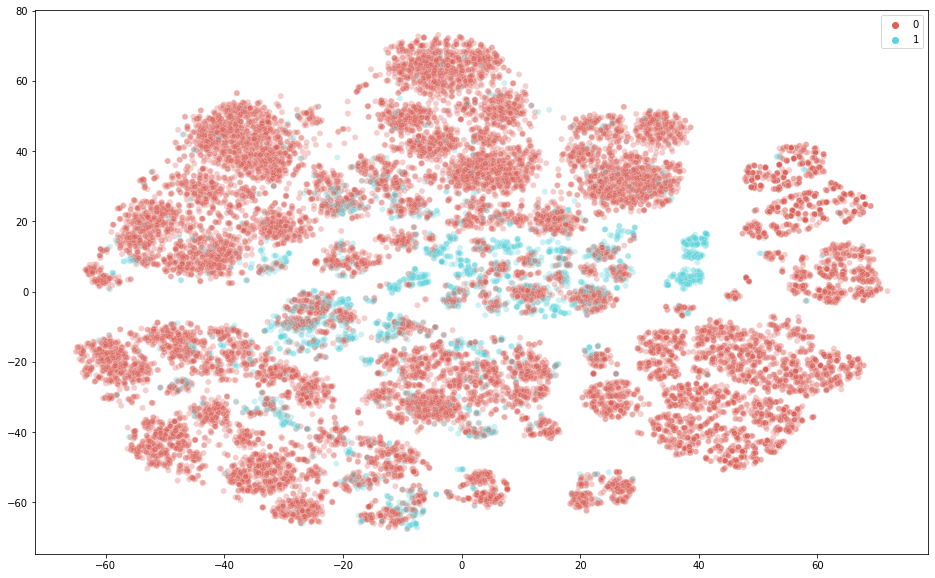

In [528]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=anomaly_detection_results,
    palette=sns.color_palette("hls", 2),
    data=tsne_result,
    legend="full",
    alpha=0.3)

In [529]:
np.unique(anomaly_detection_results, return_counts=True)

(array([0, 1]), array([22124,  2459]))

In [352]:
df.iloc[df_partial.index][[True if anom == -1 else False for anom in anomaly_detection_results]]

,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,iEnglish,iFeb55,...,iSubfam2,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,dYrsserv
1109251,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2303658,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
445130,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
884809,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2322655,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997233,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
801792,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1063296,3,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66087,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


In [331]:
from sklearn.ensemble import IsolationForest

In [332]:
anomaly_clf = IsolationForest(max_features=1, n_estimators=1000)
anomaly_detection_results = anomaly_clf.fit_predict(df_partial)

In [333]:
np.unique(anomaly_detection_results, return_counts=True)

(array([-1,  1]), array([   10, 24573]))

<AxesSubplot:>

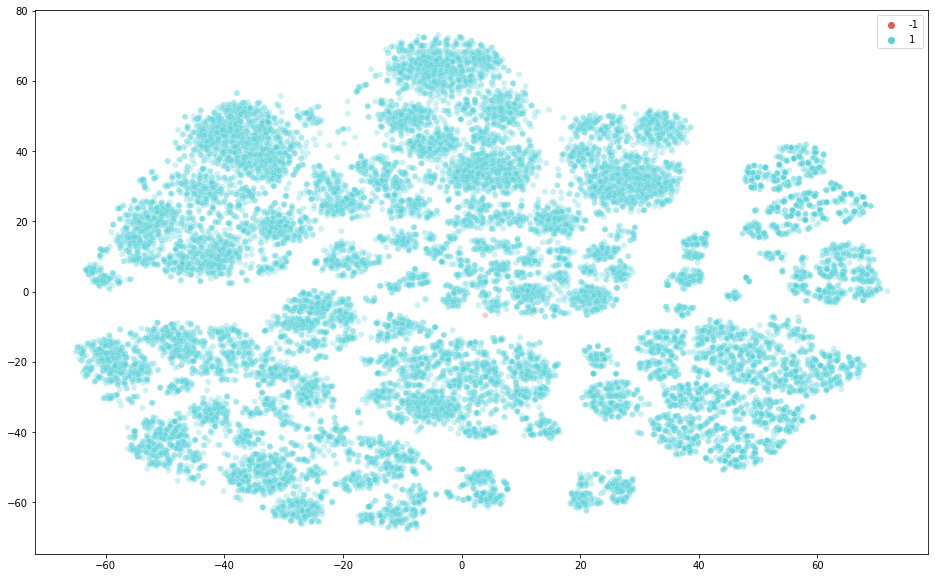

In [319]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=anomaly_detection_results,
    palette=sns.color_palette("hls", 2),
    data=tsne_result,
    legend="full",
    alpha=0.3)

In [413]:
mca.explained_inertia_

array([0.81783642, 0.16750716, 0.05844336, 0.03884741, 0.01983496,
       0.01302557, 0.01102967, 0.00826792])